Cette partie du projet diffère du modèle personnel dans le fait que les modèles de reconnaissance d'activités sont construits à partir des données provenant de plusieurs sujets et non d'un seul sujet. Certaines parties se retrouvent aussi dans le modèle personnel et est plus explicité (Mise en place, description des données, etc.) dans ce modèle pour éviter la redondance d'information.

L'étude pour la séléction de données comporte : l'études des données venant de l'accéléromètre et du gyroscope des smartwatches, ensuite celle provenant de l'accéléromètre des téléphones (les données du gyroscope du téléphone ne sont pas fiables et ne seront donc pas utilisées cf. rapport)
Ensuite, différents modèles vont être testés pour chacun de ces quatres types de données. 

L'étude va se dérouler selon le plan suivant : 
- Mise en place 
- Récupération des données
- Etude des données : 
    vérification de la qualité des données, affichage des détails statistiques des données et leur compréhension, histogramme, visualisation de la matrice d'intercorrélation
- Modélisation avec : arbre de décision, random forest, SVM holdout (pour déterminer les paramètres à utiliser pour la fonction SVC), SVM avec validation croisée, Bayésien naïf 


### Mise en place

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


### Récupération des données

In [2]:
import zipfile
import urllib

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/00507/"
WISDM_PATH = os.path.join("datasets", "wisdm")
WISDM_URL = DOWNLOAD_ROOT + "wisdm-dataset.zip"

def fetch_wisdm_data(wisdm_url=WISDM_URL, wisdm_path=WISDM_PATH):
    if not os.path.isdir(wisdm_path):
        os.makedirs(wisdm_path)
    zip_path = os.path.join(wisdm_path, "wisdm-dataset.zip")
    if not os.path.isfile(zip_path):
        urllib.request.urlretrieve(wisdm_url, zip_path)
    uncompressed_path = os.path.join(wisdm_path, "wisdm-dataset")
    if not os.path.isdir(uncompressed_path):
        with zipfile.ZipFile(zip_path,"r") as zip_ref:
            zip_ref.extractall(wisdm_path)

### Etude des données venant de l'accéléromètre des smartwatches 

In [3]:
import random
from random import randint

import arff
import pandas as pd

#Récupération des données d'une seule instance
def load_wisdm_data(subjectId, device, sensor, wisdm_path=WISDM_PATH):
    subjectIdStr = str(subjectId)
    arffPath = os.path.join(WISDM_PATH,'wisdm-dataset','arff_files',device,sensor,'data_'+subjectIdStr+'_'+sensor+'_'+device+'.arff')
    return arff.load(open(arffPath, 'r'))

# Création d'un dataframe à partir des données d'un sujet
wisdmExample = load_wisdm_data(1600, 'watch', 'accel')
attributesName = [wisdmExample['attributes'][i][0] for i in range (len(wisdmExample['attributes']))]
data = pd.DataFrame(data = wisdmExample['data'], columns = attributesName) 


In [4]:
# Récupération des données de plusieurs instances
SUBJECT_NUMBER = 51
FIRST_SUBJECT_ID=1600
l = [i+FIRST_SUBJECT_ID for i in range(SUBJECT_NUMBER)]
SUBJECTSID= l.remove(1614) #Le sujet 1614 n'est pas dans la liste ...

def load_multiple_wisdm_data(subjectToExtractNumber, device, sensor, method):
    d = []
    random.seed(1) #for reproductibility
    subjectToExtract = random.sample(l,subjectToExtractNumber)
    
    # Un seul dataframe pour tous les sujets
    if(method==1): 
        subjectsDf = pd.DataFrame(data = wisdmExample['data'], columns = attributesName)
        for i in range(subjectToExtractNumber):
            dataArff = load_wisdm_data(subjectToExtract[i], device, sensor)
            subjectDf = pd.DataFrame(data = dataArff['data'], columns = attributesName) 
            subjectsDf = subjectsDf.append(subjectDf)
        return subjectsDf 
    
    # Possibilité de créer une collection de dataFrames
    if(method==2):
        for i in range(subjectToExtractNumber):
            d.append(load_wisdm_data(subjectToExtract[i], device, sensor))
        return d      

In [5]:
#Methode 1 : Récupération de toutes les données provenant des accéléromètre des smartwatches 
DATA_NUMBER = 50
data_watch_accel = load_multiple_wisdm_data(DATA_NUMBER, 'watch', 'accel', 1)

In [6]:

#Methode 2 : Creation d'une collection de 10 dataframes correspondant aux données de 10 personnes
def create_dataFrame_fromArff(collection):
    dataFrameCollection = {}
    for i in range(len(collection)):
        dataOnePerson = collection[i]
        dataFrameCollection[i] = pd.DataFrame(data = dataOnePerson['data'], columns = attributesName) 
    return dataFrameCollection

collection2 = load_multiple_wisdm_data(10, 'watch', 'accel',2)
dataFrame = create_dataFrame_fromArff(collection2)

#### Vérification de la qualité des données

In [7]:
import numpy as np

# Vérification de valeurs manquantes
data_watch_accel = data_watch_accel.replace('?',np.NaN)
print('Number of instances = %d' % (data_watch_accel.shape[0]))
print('Number of attributes = %d' % (data_watch_accel.shape[1]))

print('Number of missing values:')
for col in data_watch_accel.columns:
    print('\t%s: %d' % (col,data_watch_accel[col].isna().sum()))

Number of instances = 18538
Number of attributes = 93
Number of missing values:
	ACTIVITY: 0
	X0: 0
	X1: 0
	X2: 0
	X3: 0
	X4: 0
	X5: 0
	X6: 0
	X7: 0
	X8: 0
	X9: 0
	Y0: 0
	Y1: 0
	Y2: 0
	Y3: 0
	Y4: 0
	Y5: 0
	Y6: 0
	Y7: 0
	Y8: 0
	Y9: 0
	Z0: 0
	Z1: 0
	Z2: 0
	Z3: 0
	Z4: 0
	Z5: 0
	Z6: 0
	Z7: 0
	Z8: 0
	Z9: 0
	XAVG: 0
	YAVG: 0
	ZAVG: 0
	XPEAK: 0
	YPEAK: 0
	ZPEAK: 0
	XABSOLDEV: 0
	YABSOLDEV: 0
	ZABSOLDEV: 0
	XSTANDDEV: 0
	YSTANDDEV: 0
	ZSTANDDEV: 0
	XVAR: 0
	YVAR: 0
	ZVAR: 0
	XMFCC0: 0
	XMFCC1: 0
	XMFCC2: 0
	XMFCC3: 0
	XMFCC4: 0
	XMFCC5: 0
	XMFCC6: 0
	XMFCC7: 0
	XMFCC8: 0
	XMFCC9: 0
	XMFCC10: 0
	XMFCC11: 0
	XMFCC12: 0
	YMFCC0: 0
	YMFCC1: 0
	YMFCC2: 0
	YMFCC3: 0
	YMFCC4: 0
	YMFCC5: 0
	YMFCC6: 0
	YMFCC7: 0
	YMFCC8: 0
	YMFCC9: 0
	YMFCC10: 0
	YMFCC11: 0
	YMFCC12: 0
	ZMFCC0: 0
	ZMFCC1: 0
	ZMFCC2: 0
	ZMFCC3: 0
	ZMFCC4: 0
	ZMFCC5: 0
	ZMFCC6: 0
	ZMFCC7: 0
	ZMFCC8: 0
	ZMFCC9: 0
	ZMFCC10: 0
	ZMFCC11: 0
	ZMFCC12: 0
	XYCOS: 0
	XZCOS: 0
	YZCOS: 0
	XYCOR: 0
	XZCOR: 0
	YZCOR: 0
	RESULTANT: 0
	class: 0


Aucun attribut de chaque sujet ne possède de valeurs manquantes néanmoins, en regardant directement dans le dossier contenant les données, on remarque que le sujet 1614 y est absent et ne présente aucune informations. 

In [8]:
# Vérification de doublons
dups = data_watch_accel.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 327


Ce résultat suggère qu'il y a 327 doublons dans les données. Ces doublons peuvent provenir du fait que différents sujets effectuent une même activité. Dans la suite, nous allons supposer qu'ils proviennent d'un même sujet et nous supprimerons donc ces doublons.

In [9]:
# Suppresion des doublons
print('Number of rows before discarding duplicates = %d' % (data_watch_accel.shape[0]))
data_watch_accel = data_watch_accel.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data_watch_accel.shape[0]))

Number of rows before discarding duplicates = 18538
Number of rows after discarding duplicates = 18211


#### Compréhension des données

In [10]:
data_watch_accel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18211 entries, 0 to 323
Data columns (total 93 columns):
ACTIVITY     18211 non-null object
X0           18211 non-null float64
X1           18211 non-null float64
X2           18211 non-null float64
X3           18211 non-null float64
X4           18211 non-null float64
X5           18211 non-null float64
X6           18211 non-null float64
X7           18211 non-null float64
X8           18211 non-null float64
X9           18211 non-null float64
Y0           18211 non-null float64
Y1           18211 non-null float64
Y2           18211 non-null float64
Y3           18211 non-null float64
Y4           18211 non-null float64
Y5           18211 non-null float64
Y6           18211 non-null float64
Y7           18211 non-null float64
Y8           18211 non-null float64
Y9           18211 non-null float64
Z0           18211 non-null float64
Z1           18211 non-null float64
Z2           18211 non-null float64
Z3           18211 non-null fl

In [11]:
data_watch_accel.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.0,0.0,0.0,0.045,0.090,0.190,0.215,0.210,0.135,...,0.504662,0.498178,-0.395887,-0.105039,-0.263814,-0.035912,-0.305539,-0.292265,12.7783,1600
1,A,0.0,0.0,0.0,0.000,0.030,0.250,0.305,0.225,0.125,...,0.497101,0.490714,-0.517585,-0.493655,0.208926,-0.166636,0.071774,-0.070860,12.8712,1600
2,A,0.0,0.0,0.0,0.000,0.015,0.280,0.300,0.210,0.140,...,0.438027,0.432398,-0.573148,-0.468498,0.001704,-0.090878,0.005053,-0.382557,12.5949,1600
3,A,0.0,0.0,0.0,0.005,0.070,0.245,0.275,0.220,0.130,...,0.447493,0.441743,-0.514097,-0.232246,-0.080241,-0.117089,0.137656,-0.265747,12.3521,1600
4,A,0.0,0.0,0.0,0.000,0.015,0.260,0.325,0.230,0.110,...,0.433304,0.427736,-0.461254,0.084470,-0.418888,-0.097265,-0.118795,-0.414198,12.4168,1600


#### Affichage des détails statistiques des sujets 

In [12]:
data_watch_accel.describe(include='all')

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
count,18211,18211.000000,18211.000000,18211.000000,18211.00000,18211.000000,18211.000000,18211.000000,18211.000000,18211.000000,...,18211.000000,18211.000000,18211.000000,18211.000000,18211.000000,18211.000000,18211.000000,18211.000000,18211.000000,18211
unique,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
top,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1638
freq,1046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,803
mean,NaN,0.358886,0.182372,0.122301,0.06850,0.064987,0.117053,0.044502,0.018739,0.008584,...,0.447762,0.442008,0.045477,-0.098927,-0.218521,-0.129082,0.063720,0.097971,10.674314,NaN
std,NaN,0.396929,0.285813,0.239773,0.16454,0.130877,0.231350,0.099598,0.042329,0.021169,...,0.161892,0.159811,0.719382,0.647738,0.640129,0.428054,0.466765,0.439195,1.818960,NaN
min,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.304238,-0.300329,-0.999989,-0.999997,-0.999997,-0.998457,-0.999672,-0.999763,9.149170,NaN
25%,NaN,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.353036,0.348499,-0.642041,-0.689939,-0.838056,-0.416285,-0.269153,-0.205732,9.778145,NaN
50%,NaN,0.175000,0.045000,0.015000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.438460,0.432826,0.034286,-0.134943,-0.302297,-0.125595,0.076433,0.110010,9.904520,NaN
75%,NaN,0.755000,0.210000,0.115000,0.07000,0.090000,0.120000,0.035000,0.010000,0.005000,...,0.558284,0.551110,0.793998,0.422072,0.263855,0.155470,0.421547,0.417042,10.802600,NaN


In [13]:
pd.set_option('display.max_rows', 50)
print('Covariance')
data_watch_accel.cov()

Covariance


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
X0,0.157552,-0.030058,-0.032447,-0.017648,-0.017345,-0.036973,-0.013135,-0.005094,-0.002080,-0.002773,...,-0.000664,-0.000656,-0.000648,0.163605,-0.055605,-0.000709,-0.032439,0.032166,0.005999,-0.042378
X1,-0.030058,0.081689,-0.003661,-0.008601,-0.008633,-0.018615,-0.006800,-0.002715,-0.001147,-0.001461,...,-0.002946,-0.002912,-0.002875,0.073418,-0.045857,-0.032835,-0.007573,0.014745,0.010110,-0.095581
X2,-0.032447,-0.003661,0.057491,-0.001015,-0.003220,-0.010570,-0.003914,-0.001503,-0.000589,-0.000573,...,-0.000005,-0.000005,-0.000005,-0.046856,0.044267,-0.016588,0.012164,0.000611,0.006913,-0.043482
X3,-0.017648,-0.008601,-0.001015,0.027073,0.003496,-0.002442,-0.000909,-0.000210,0.000002,0.000253,...,0.002199,0.002173,0.002145,-0.035584,0.016309,0.008209,0.008030,-0.007379,-0.004118,0.009163
X4,-0.017345,-0.008633,-0.003220,0.003496,0.017129,0.003996,0.002282,0.001150,0.000507,0.000639,...,0.003609,0.003567,0.003521,-0.027642,0.007586,0.009639,0.005452,-0.008931,-0.004616,0.029165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YZCOS,-0.000709,-0.032835,-0.016588,0.008209,0.009639,0.013069,0.010411,0.004258,0.002012,0.002534,...,0.011602,0.011467,0.011319,-0.056632,0.025809,0.409765,-0.000343,-0.066988,-0.022152,0.207246
XYCOR,-0.032439,-0.007573,0.012164,0.008030,0.005452,0.016038,-0.000409,-0.000392,-0.000209,-0.000664,...,0.002470,0.002442,0.002410,-0.061631,0.009577,-0.000343,0.183230,0.021675,0.015436,0.016951
XZCOR,0.032166,0.014745,0.000611,-0.007379,-0.008931,-0.017575,-0.006938,-0.003543,-0.001625,-0.001530,...,0.002705,0.002673,0.002639,0.064411,-0.042955,-0.066988,0.021675,0.217870,-0.027441,-0.069872
YZCOR,0.005999,0.010110,0.006913,-0.004118,-0.004616,-0.005273,-0.003821,-0.002048,-0.000926,-0.002221,...,-0.006304,-0.006231,-0.006151,0.030031,-0.046675,-0.022152,0.015436,-0.027441,0.192892,-0.091359


In [14]:
correlationMatrix = data_watch_accel.corr()
print('Correlation :')
data_watch_accel.corr()

Correlation :


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
X0,1.000000,-0.264951,-0.340923,-0.270214,-0.333880,-0.402626,-0.332265,-0.303191,-0.247570,-0.176973,...,-0.010214,-0.010214,-0.010214,0.572961,-0.216272,-0.002789,-0.190920,0.173614,0.034411,-0.058695
X1,-0.264951,1.000000,-0.053419,-0.182884,-0.230784,-0.281527,-0.238880,-0.224378,-0.189501,-0.129465,...,-0.062932,-0.062932,-0.062932,0.357076,-0.247697,-0.179466,-0.061897,0.110522,0.080543,-0.183852
X2,-0.340923,-0.053419,1.000000,-0.025728,-0.102611,-0.190542,-0.163891,-0.148111,-0.116080,-0.060517,...,-0.000135,-0.000135,-0.000135,-0.271645,0.285025,-0.108077,0.118520,0.005455,0.065646,-0.099698
X3,-0.270214,-0.182884,-0.025728,1.000000,0.162338,-0.064152,-0.055454,-0.030117,0.000515,0.038961,...,0.081592,0.081592,0.081592,-0.300621,0.153023,0.077936,0.114009,-0.096074,-0.056980,0.030615
X4,-0.333880,-0.230784,-0.102611,0.162338,1.000000,0.131960,0.175031,0.207521,0.183037,0.123708,...,0.168343,0.168343,0.168343,-0.293591,0.089482,0.115056,0.097324,-0.146206,-0.080309,0.122510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YZCOS,-0.002789,-0.179466,-0.108077,0.077936,0.115056,0.088247,0.163302,0.157143,0.148482,0.100277,...,0.110647,0.110647,0.110647,-0.122980,0.062245,1.000000,-0.001253,-0.224198,-0.078793,0.177990
XYCOR,-0.190920,-0.061897,0.118520,0.114009,0.097324,0.161952,-0.009591,-0.021631,-0.023054,-0.039280,...,0.035233,0.035233,0.035233,-0.200142,0.034542,-0.001253,1.000000,0.108481,0.082105,0.021771
XZCOR,0.173614,0.110522,0.005455,-0.096074,-0.146206,-0.162755,-0.149241,-0.179304,-0.164470,-0.083032,...,0.035374,0.035374,0.035374,0.191822,-0.142074,-0.224198,0.108481,1.000000,-0.133860,-0.082297
YZCOR,0.034411,0.080543,0.065646,-0.056980,-0.080309,-0.051892,-0.087352,-0.110179,-0.099582,-0.128101,...,-0.087634,-0.087634,-0.087634,0.095051,-0.164069,-0.078793,0.082105,-0.133860,1.000000,-0.114360


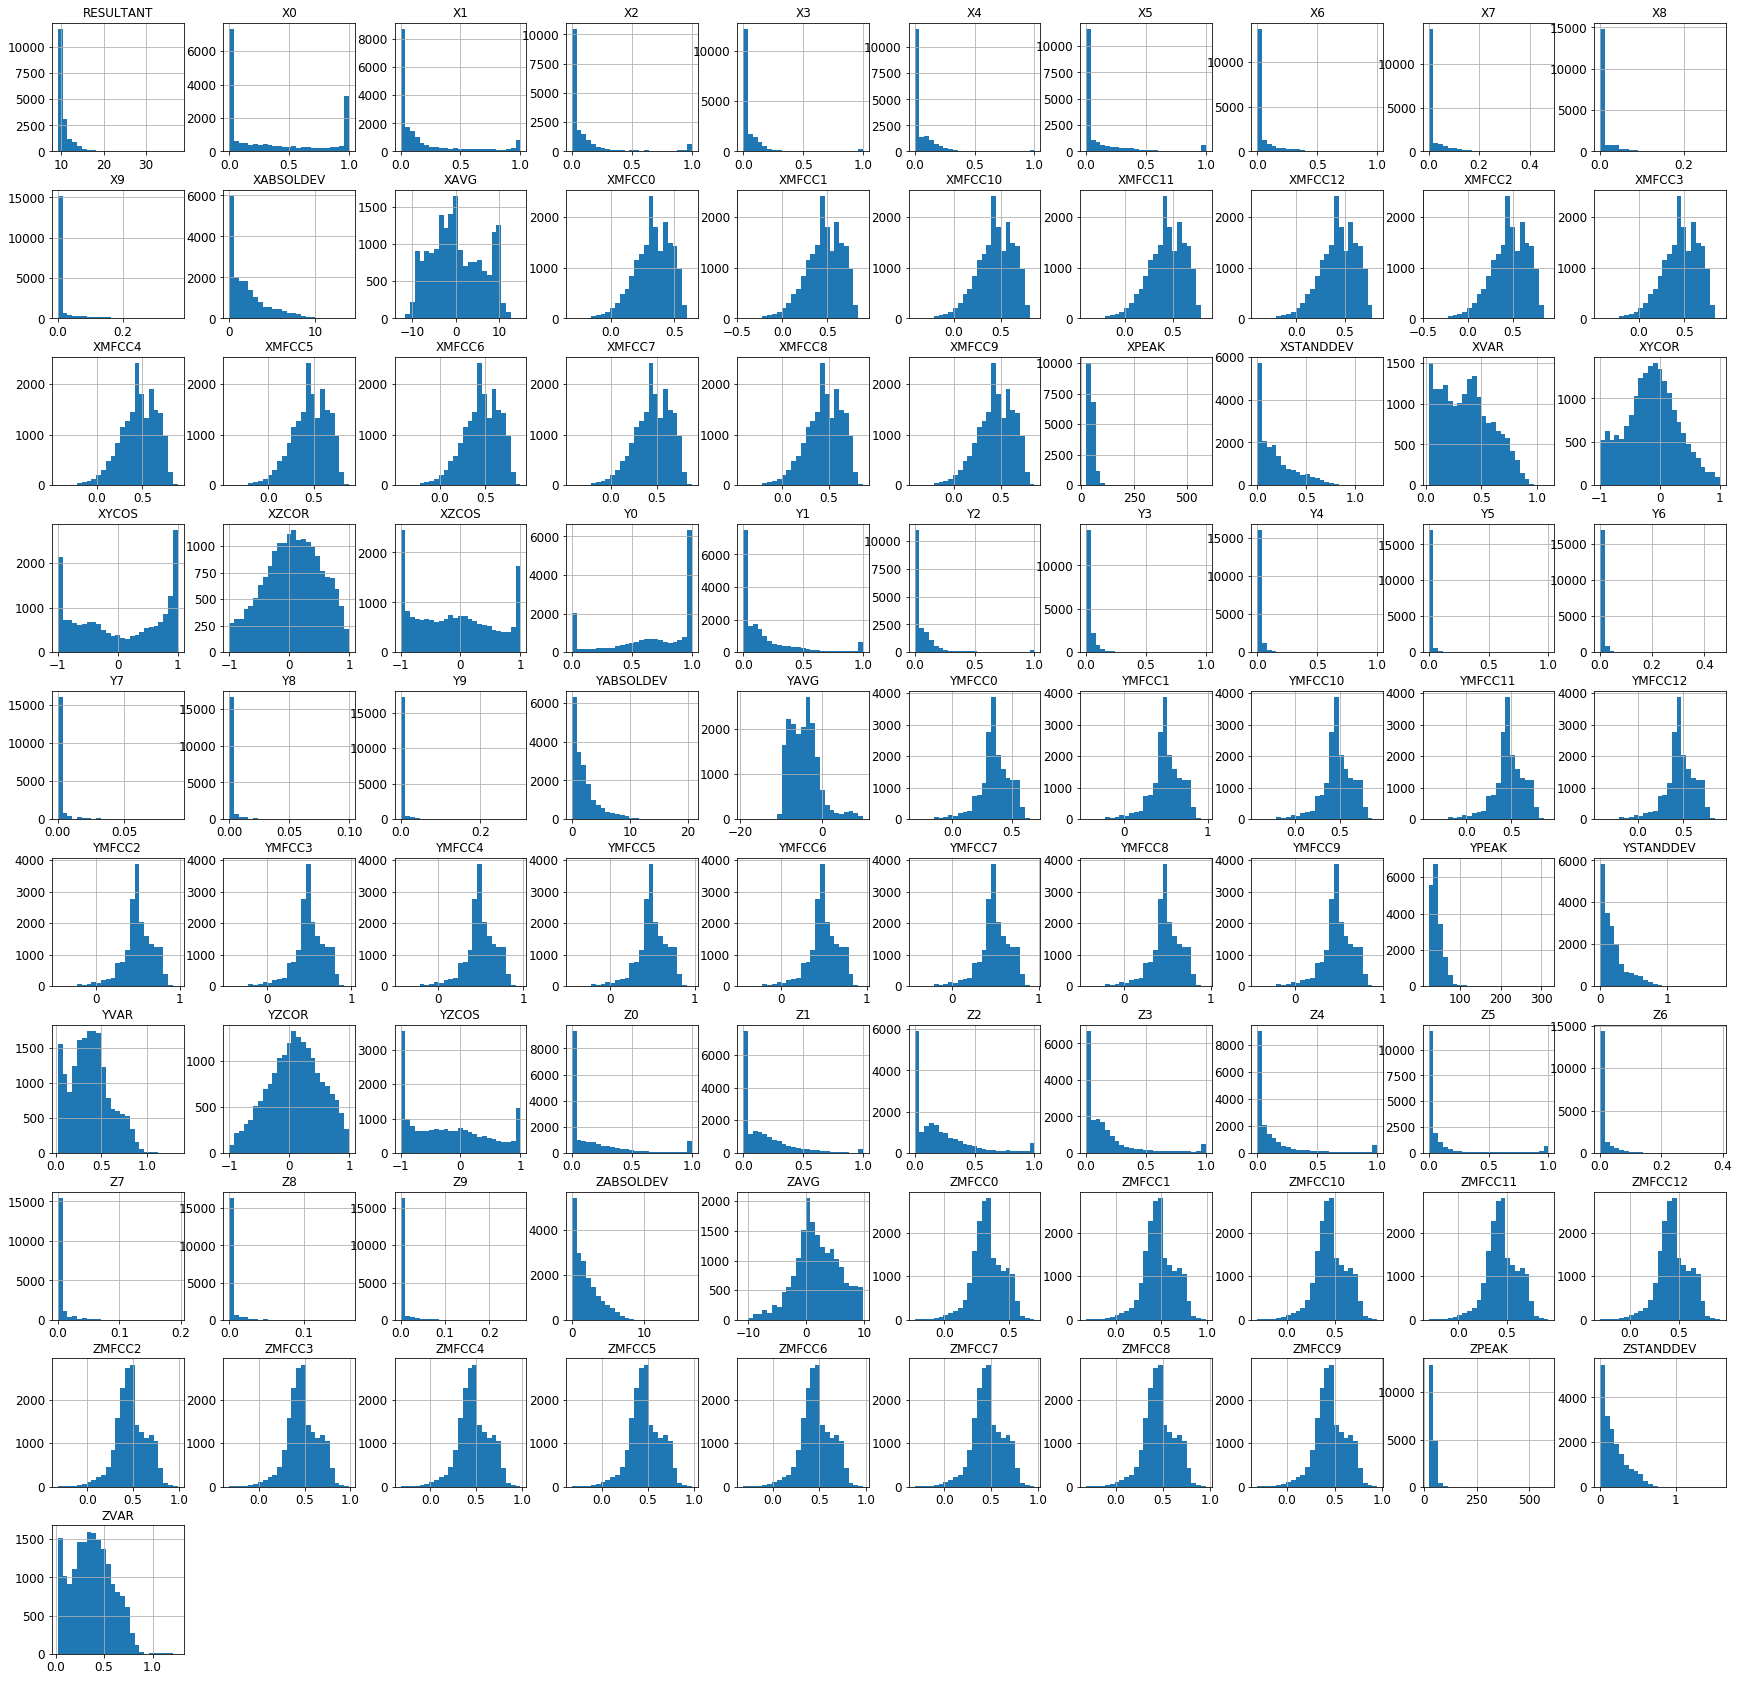

In [15]:
data_watch_accel.hist(bins = 25, figsize=(30,30))
plt.show()

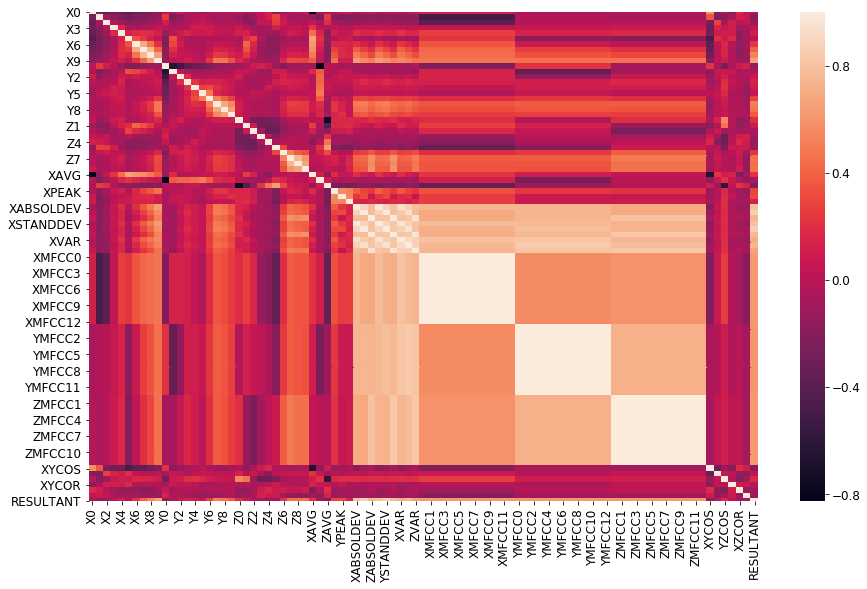

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(data_watch_accel.corr())
plt.show()

On remarque que les histogrammes de certains attributs semblent similaires, comme ceux des attributs XMFCC{0-12}, les attributs YMFCC{0-12} et enfin ZMFCC{0-12}. Nous vérifierons par la suite la valeur de la corrélation entre ces attributs.

In [17]:
thresholdCorrelation = 0.80
correlationXMFCC = correlationMatrix["XMFCC0"].sort_values(ascending=False)**2
correlationXMFCC[correlationXMFCC>=thresholdCorrelation]

XMFCC0     1.0
XMFCC1     1.0
XMFCC3     1.0
XMFCC5     1.0
XMFCC2     1.0
XMFCC4     1.0
XMFCC6     1.0
XMFCC9     1.0
XMFCC7     1.0
XMFCC8     1.0
XMFCC10    1.0
XMFCC11    1.0
XMFCC12    1.0
Name: XMFCC0, dtype: float64

In [18]:
correlationYMFCC = correlationMatrix["YMFCC0"].sort_values(ascending=False)**2
correlationYMFCC[correlationYMFCC>=thresholdCorrelation]

YMFCC0     1.0
YMFCC3     1.0
YMFCC1     1.0
YMFCC2     1.0
YMFCC4     1.0
YMFCC5     1.0
YMFCC6     1.0
YMFCC7     1.0
YMFCC8     1.0
YMFCC10    1.0
YMFCC9     1.0
YMFCC11    1.0
YMFCC12    1.0
Name: YMFCC0, dtype: float64

In [19]:
correlationZMFCC = correlationMatrix["ZMFCC0"].sort_values(ascending=False)**2
correlationZMFCC[correlationZMFCC>=thresholdCorrelation]

ZMFCC0     1.0
ZMFCC4     1.0
ZMFCC1     1.0
ZMFCC3     1.0
ZMFCC2     1.0
ZMFCC6     1.0
ZMFCC5     1.0
ZMFCC7     1.0
ZMFCC9     1.0
ZMFCC8     1.0
ZMFCC10    1.0
ZMFCC11    1.0
ZMFCC12    1.0
Name: ZMFCC0, dtype: float64

Remarques : La corrélation entre les attributs XMFCC{0-12} est égale à 1. De même pour YMFCC{0-12} et ZMFCC{0-12}. On va donc ne prendre que un de chaque attribut par la suite

In [20]:
mfccAttributsToDrop = ['XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4', 'XMFCC5', 'XMFCC6', 'XMFCC7',
       'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12', 'YMFCC1',
       'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5', 'YMFCC6', 'YMFCC7', 'YMFCC8',
       'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12', 'ZMFCC1', 'ZMFCC2',
       'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6', 'ZMFCC7', 'ZMFCC8', 'ZMFCC9',
       'ZMFCC10', 'ZMFCC11', 'ZMFCC12']

In [21]:
correlationX = correlationMatrix["XABSOLDEV"].sort_values(ascending=False)**2
correlationX[correlationX>=thresholdCorrelation]

XABSOLDEV    1.000000
XSTANDDEV    0.984079
XVAR         0.895046
Name: XABSOLDEV, dtype: float64

In [22]:
correlationY = correlationMatrix["YABSOLDEV"].sort_values(ascending=False)**2
correlationY[correlationY>=thresholdCorrelation]

YABSOLDEV    1.000000
YSTANDDEV    0.984812
YVAR         0.879381
Name: YABSOLDEV, dtype: float64

In [23]:
correlationZ = correlationMatrix["ZABSOLDEV"].sort_values(ascending=False)**2
correlationZ[correlationZ>=thresholdCorrelation]

ZABSOLDEV    1.000000
ZSTANDDEV    0.982274
ZVAR         0.905779
Name: ZABSOLDEV, dtype: float64

In [24]:
correlationXVAR = correlationMatrix["XVAR"].sort_values(ascending=False)**2
correlationXVAR[correlationXVAR>=thresholdCorrelation]

XVAR         1.000000
XSTANDDEV    0.926613
XABSOLDEV    0.895046
YVAR         0.838925
Name: XVAR, dtype: float64

Les attributs 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV' présentent une forte corrélation avec 'XSTANDDEV', 'YSTANDDEV' et 'ZSTANDDEV'. De plus ils ont aussi une forte corrélation avec 'XVAR', 'YVAR' et 'ZVAR'.

On peut donc ne conserver que 'XABSOLDEV' par exemple et voir lors de la modélisation si cela affecte les performances du classificateur utilisé.

In [25]:
XYZattributsToDrop = ['YABSOLDEV', 'ZABSOLDEV','XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR']

#### Visualisation de la correlation entre les attributs MFCC

In [26]:
# Liste initiale des attributs 
data_watch_accel.columns

Index(['ACTIVITY', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1',
       'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG',
       'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV',
       'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR', 'XMFCC0',
       'XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4', 'XMFCC5', 'XMFCC6', 'XMFCC7',
       'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12', 'YMFCC0', 'YMFCC1',
       'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5', 'YMFCC6', 'YMFCC7', 'YMFCC8',
       'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12', 'ZMFCC0', 'ZMFCC1', 'ZMFCC2',
       'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6', 'ZMFCC7', 'ZMFCC8', 'ZMFCC9',
       'ZMFCC10', 'ZMFCC11', 'ZMFCC12', 'XYCOS', 'XZCOS', 'YZCOS', 'XYCOR',
       'XZCOR', 'YZCOR', 'RESULTANT', 'class'],
      dtype='object')

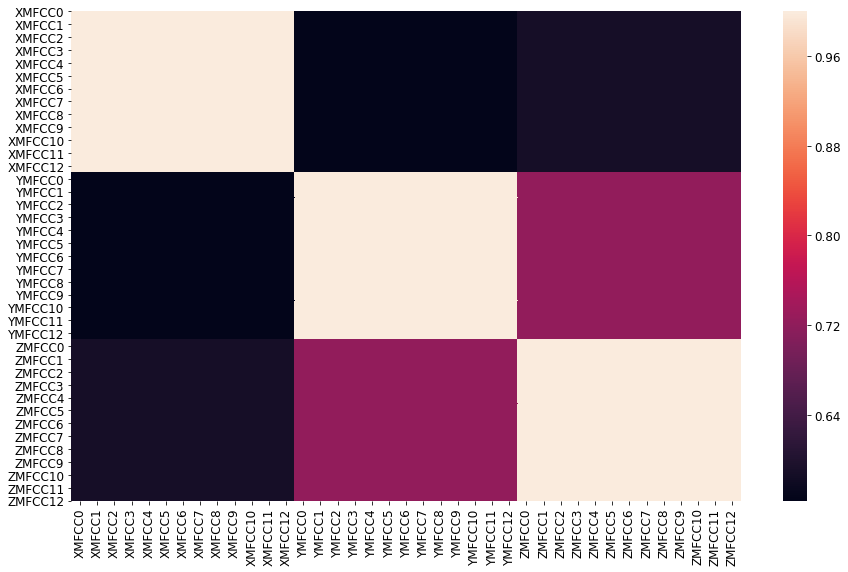

In [27]:
mfccAttributs = ['XMFCC0','XMFCC1', 'XMFCC2', 'XMFCC3', 'XMFCC4', 'XMFCC5', 'XMFCC6', 'XMFCC7',
       'XMFCC8', 'XMFCC9', 'XMFCC10', 'XMFCC11', 'XMFCC12', 'YMFCC0', 'YMFCC1',
       'YMFCC2', 'YMFCC3', 'YMFCC4', 'YMFCC5', 'YMFCC6', 'YMFCC7', 'YMFCC8',
       'YMFCC9', 'YMFCC10', 'YMFCC11', 'YMFCC12', 'ZMFCC0', 'ZMFCC1', 'ZMFCC2',
       'ZMFCC3', 'ZMFCC4', 'ZMFCC5', 'ZMFCC6', 'ZMFCC7', 'ZMFCC8', 'ZMFCC9',
       'ZMFCC10', 'ZMFCC11', 'ZMFCC12']

# Fonction qui permet de selectionner les données selon les attributs qui nous intéressent
def attributsSelection(collection, attributs):
    return collection[attributs].copy()

mfccData = attributsSelection(data_watch_accel, mfccAttributs)

import seaborn as sns
fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(mfccData.corr())
plt.show()

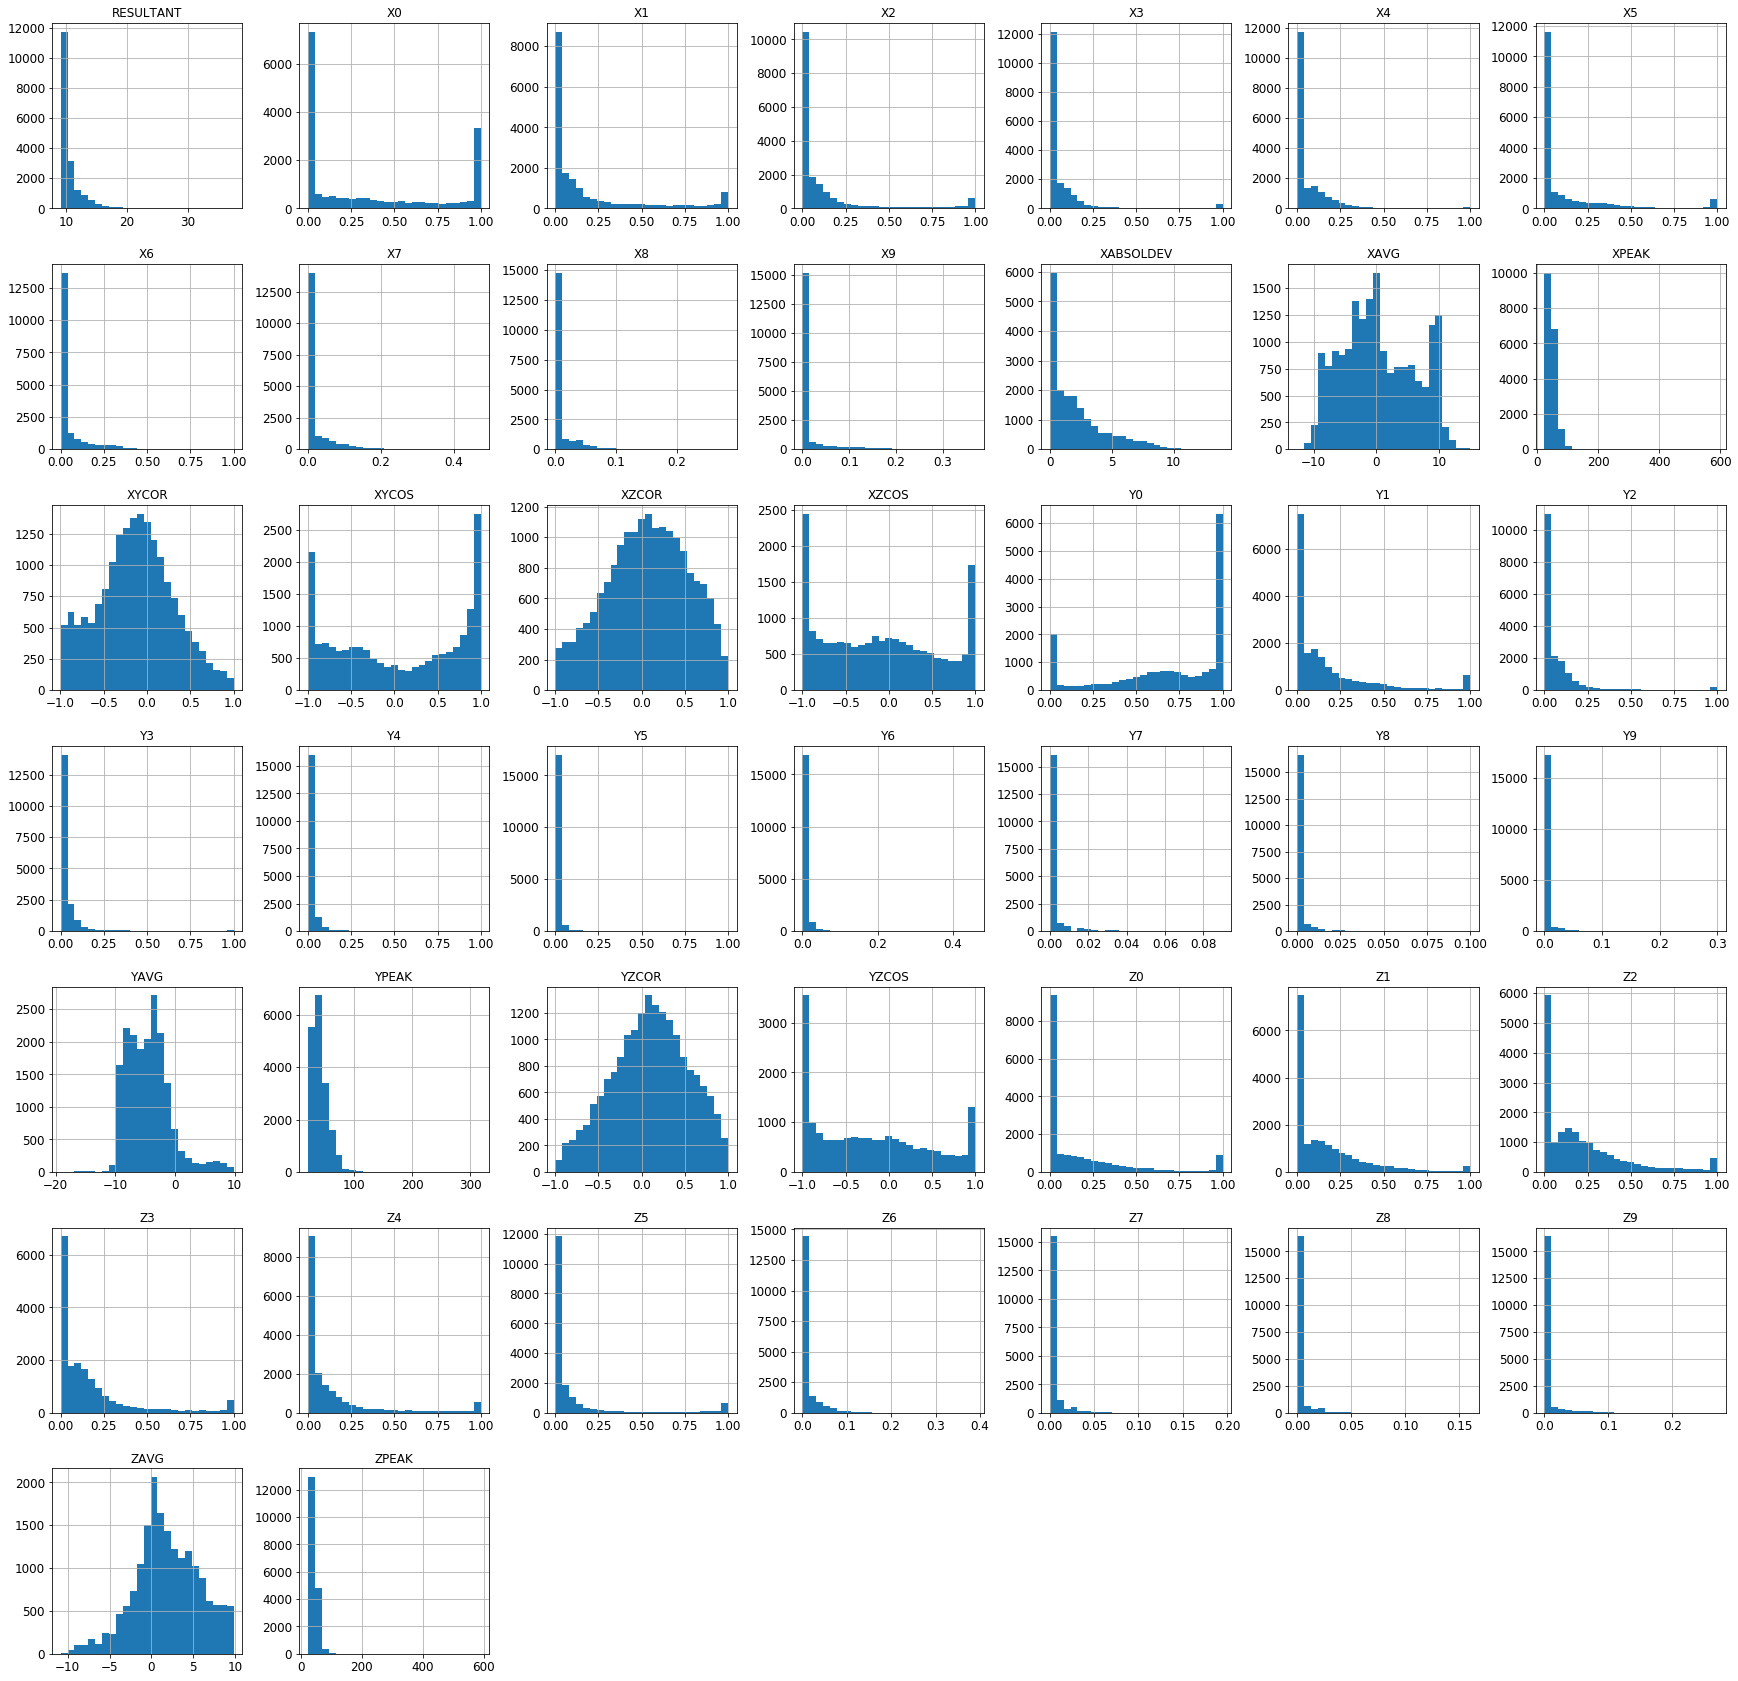

In [28]:
# Visualisation de l'histogramme sans les attributs MFCC,{Y,Z}ABSOLDEV, {X,Y,Z}STANDDEV et {X,Y,Z}VAR
irrelevantAtrribut = XYZattributsToDrop+mfccAttributs
reduced_data_watch_accel = data_watch_accel.drop(irrelevantAtrribut, axis=1)
reduced_data_watch_accel.hist(bins = 25, figsize=(30,30))
plt.show()

Sur ces histogrammes, nous pouvons remarquer que la variance des attributs X{4, 6, 7, 8, 9}, Y{3 - 9} et Z{6 - 9} sont très faibles. Il peut être intéressant de ne pas prendre en compte ces attributs lors de la modélisation.

### Corrélation entre les données des différents capteurs et appareils

In [29]:
# Récupération des données du gyroscope des smartwatchs
data_watch_gyro = load_multiple_wisdm_data(DATA_NUMBER, 'watch', 'gyro', 1)

# Récupération des données de l'accéléromètre des smartphones
data_phone_accel = load_multiple_wisdm_data(DATA_NUMBER, 'phone', 'accel', 1)

# Récupération des données du gyroscope des smartphones
data_phone_gyro = load_multiple_wisdm_data(DATA_NUMBER, 'phone', 'gyro', 1)

thresholdCorrelation2 = 0.7

In [30]:
# Corrélation entre les appareils
devices_correlation1= data_watch_gyro.corrwith(data_watch_accel, axis = 0).sort_values(ascending=False)**2
devices_correlation1[devices_correlation1>thresholdCorrelation2]

Series([], dtype: float64)

In [31]:
devices_correlation2= data_phone_gyro.corrwith(data_phone_accel, axis = 0).sort_values(ascending=False)**2
devices_correlation2[devices_correlation2>thresholdCorrelation2]

Series([], dtype: float64)

In [32]:
# Corrélation entre les capteurs 
sensors_correlation1= data_watch_accel.corrwith(data_phone_accel, axis = 0).sort_values(ascending=False)**2
sensors_correlation1[sensors_correlation1>thresholdCorrelation2]

Series([], dtype: float64)

In [33]:
sensors_correlation2= data_watch_gyro.corrwith(data_phone_gyro, axis = 0).sort_values(ascending=False)**2
sensors_correlation2[sensors_correlation2>thresholdCorrelation2]

Series([], dtype: float64)

Il n'y a pas d'attributs avec une grande corrélation entre les données qui proviennent des smartphones et des smartwatches et de leurs capteurs. Le processus de séléction des données pour la modélisation sera donc différent pour chaque catégorie de données.

### Etude des données venant du gyroscope des smarwatches

#### Vérification de la qualité des données

In [34]:
# Vérification de valeurs manquantes
data_watch_gyro = data_watch_gyro.replace('?',np.NaN)
print('Number of instances = %d' % (data_watch_gyro.shape[0]))
print('Number of attributes = %d' % (data_watch_gyro.shape[1]))

print('Number of missing values:')
for col in data_watch_gyro.columns:
    print('\t%s: %d' % (col,data_watch_gyro[col].isna().sum()))

Number of instances = 16860
Number of attributes = 93
Number of missing values:
	ACTIVITY: 0
	X0: 0
	X1: 0
	X2: 0
	X3: 0
	X4: 0
	X5: 0
	X6: 0
	X7: 0
	X8: 0
	X9: 0
	Y0: 0
	Y1: 0
	Y2: 0
	Y3: 0
	Y4: 0
	Y5: 0
	Y6: 0
	Y7: 0
	Y8: 0
	Y9: 0
	Z0: 0
	Z1: 0
	Z2: 0
	Z3: 0
	Z4: 0
	Z5: 0
	Z6: 0
	Z7: 0
	Z8: 0
	Z9: 0
	XAVG: 0
	YAVG: 0
	ZAVG: 0
	XPEAK: 0
	YPEAK: 0
	ZPEAK: 0
	XABSOLDEV: 0
	YABSOLDEV: 0
	ZABSOLDEV: 0
	XSTANDDEV: 0
	YSTANDDEV: 0
	ZSTANDDEV: 0
	XVAR: 0
	YVAR: 0
	ZVAR: 0
	XMFCC0: 0
	XMFCC1: 0
	XMFCC2: 0
	XMFCC3: 0
	XMFCC4: 0
	XMFCC5: 0
	XMFCC6: 0
	XMFCC7: 0
	XMFCC8: 0
	XMFCC9: 0
	XMFCC10: 0
	XMFCC11: 0
	XMFCC12: 0
	YMFCC0: 0
	YMFCC1: 0
	YMFCC2: 0
	YMFCC3: 0
	YMFCC4: 0
	YMFCC5: 0
	YMFCC6: 0
	YMFCC7: 0
	YMFCC8: 0
	YMFCC9: 0
	YMFCC10: 0
	YMFCC11: 0
	YMFCC12: 0
	ZMFCC0: 0
	ZMFCC1: 0
	ZMFCC2: 0
	ZMFCC3: 0
	ZMFCC4: 0
	ZMFCC5: 0
	ZMFCC6: 0
	ZMFCC7: 0
	ZMFCC8: 0
	ZMFCC9: 0
	ZMFCC10: 0
	ZMFCC11: 0
	ZMFCC12: 0
	XYCOS: 0
	XZCOS: 0
	YZCOS: 0
	XYCOR: 0
	XZCOR: 0
	YZCOR: 0
	RESULTANT: 0
	class: 0


Il n'y a pas de valeurs qui manquent dans les données, sauf ceux du sujet 1614.

In [35]:
# Vérification de doublons
dups = data_watch_gyro.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


Il n'y a pas de doublons dans les données

#### Compréhension des données et affichage des détails statistiques des sujets 

In [36]:
data_watch_gyro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16860 entries, 0 to 323
Data columns (total 93 columns):
ACTIVITY     16860 non-null object
X0           16860 non-null float64
X1           16860 non-null float64
X2           16860 non-null float64
X3           16860 non-null float64
X4           16860 non-null float64
X5           16860 non-null float64
X6           16860 non-null float64
X7           16860 non-null float64
X8           16860 non-null float64
X9           16860 non-null float64
Y0           16860 non-null float64
Y1           16860 non-null float64
Y2           16860 non-null float64
Y3           16860 non-null float64
Y4           16860 non-null float64
Y5           16860 non-null float64
Y6           16860 non-null float64
Y7           16860 non-null float64
Y8           16860 non-null float64
Y9           16860 non-null float64
Z0           16860 non-null float64
Z1           16860 non-null float64
Z2           16860 non-null float64
Z3           16860 non-null fl

In [37]:
data_watch_gyro.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.0,0.0,0.0,0.045,0.090,0.190,0.215,0.210,0.135,...,0.504662,0.498178,-0.395887,-0.105039,-0.263814,-0.035912,-0.305539,-0.292265,12.7783,1600
1,A,0.0,0.0,0.0,0.000,0.030,0.250,0.305,0.225,0.125,...,0.497101,0.490714,-0.517585,-0.493655,0.208926,-0.166636,0.071774,-0.070860,12.8712,1600
2,A,0.0,0.0,0.0,0.000,0.015,0.280,0.300,0.210,0.140,...,0.438027,0.432398,-0.573148,-0.468498,0.001704,-0.090878,0.005053,-0.382557,12.5949,1600
3,A,0.0,0.0,0.0,0.005,0.070,0.245,0.275,0.220,0.130,...,0.447493,0.441743,-0.514097,-0.232246,-0.080241,-0.117089,0.137656,-0.265747,12.3521,1600
4,A,0.0,0.0,0.0,0.000,0.015,0.260,0.325,0.230,0.110,...,0.433304,0.427736,-0.461254,0.084470,-0.418888,-0.097265,-0.118795,-0.414198,12.4168,1600


In [38]:
data_watch_gyro.describe(include='all')

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
count,16860,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,...,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860
unique,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
top,K,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1600
freq,972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,654
mean,NaN,0.051114,0.445547,0.456999,0.032074,0.006956,0.004122,0.001682,0.000706,0.000364,...,0.124855,0.123250,-0.059506,0.061795,0.030651,-0.067455,0.068750,0.041867,1.672001,NaN
std,NaN,0.102527,0.108698,0.115028,0.054217,0.017618,0.038658,0.017144,0.008463,0.004958,...,0.296997,0.293180,0.384691,0.393608,0.482614,0.380798,0.388830,0.483884,1.976031,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.921224,-0.909386,-0.999937,-0.996012,-0.999946,-0.987473,-0.995277,-0.997978,0.002764,NaN
25%,NaN,0.000000,0.395000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.031980,-0.031569,-0.338289,-0.202552,-0.345706,-0.345435,-0.194210,-0.334480,0.316306,NaN
50%,NaN,0.005000,0.465000,0.470000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.152609,0.150648,-0.075538,0.077651,0.034514,-0.082343,0.081737,0.047467,0.907603,NaN
75%,NaN,0.075000,0.510000,0.520000,0.050000,0.005000,0.000000,0.000000,0.000000,0.000000,...,0.357633,0.353038,0.199977,0.344136,0.411786,0.188926,0.348190,0.425735,2.433793,NaN


In [39]:
print('Covariance')
data_watch_gyro.cov()

Covariance


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
X0,0.010512,-0.006530,-0.007341,0.002286,0.000758,0.000168,0.000072,0.000023,0.000012,0.000040,...,0.015150,0.014974,0.014781,0.001997,-0.003006,0.001100,-0.003787,0.004349,0.005806,0.152148
X1,-0.006530,0.011815,0.000715,-0.002748,-0.000928,-0.001254,-0.000550,-0.000247,-0.000131,-0.000144,...,-0.009209,-0.009102,-0.008985,0.000479,-0.001686,-0.005289,0.001016,-0.003317,-0.008151,-0.129272
X2,-0.007341,0.000715,0.013231,-0.003126,-0.001051,-0.001314,-0.000571,-0.000255,-0.000136,-0.000153,...,-0.019292,-0.019067,-0.018822,0.002822,0.001206,0.002064,0.003966,-0.001858,-0.002269,-0.162745
X3,0.002286,-0.002748,-0.003126,0.002939,0.000451,0.000103,0.000047,0.000018,0.000009,0.000021,...,0.008880,0.008777,0.008664,-0.002287,0.002952,0.001961,-0.000947,0.001707,0.003295,0.064574
X4,0.000758,-0.000928,-0.001051,0.000451,0.000310,0.000194,0.000132,0.000062,0.000033,0.000038,...,0.002234,0.002208,0.002180,-0.000488,0.000148,0.000943,-0.000232,0.000045,0.001061,0.021753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YZCOS,0.001100,-0.005289,0.002064,0.001961,0.000943,-0.000738,0.000035,-0.000008,-0.000017,-0.000051,...,0.013339,0.013184,0.013014,0.018763,0.003907,0.232916,0.021586,0.000748,0.227082,0.053561
XYCOR,-0.003787,0.001016,0.003966,-0.000947,-0.000232,0.000077,-0.000016,-0.000019,-0.000019,-0.000040,...,-0.001014,-0.001002,-0.000989,0.139534,-0.001263,0.021586,0.145007,-0.003248,0.020298,-0.044830
XZCOR,0.004349,-0.003317,-0.001858,0.001707,0.000045,-0.000493,-0.000233,-0.000103,-0.000053,-0.000044,...,0.017536,0.017332,0.017110,-0.001705,0.145595,0.000748,-0.003248,0.151189,0.001555,0.078213
YZCOR,0.005806,-0.008151,-0.002269,0.003295,0.001061,0.000385,0.000002,-0.000035,-0.000035,-0.000058,...,0.016231,0.016042,0.015836,0.021662,0.000886,0.227082,0.020298,0.001555,0.234143,0.130509


In [40]:
correlationMatrix = data_watch_gyro.corr()
print('Correlation :')
data_watch_accel.corr()

Correlation :


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
X0,1.000000,-0.264951,-0.340923,-0.270214,-0.333880,-0.402626,-0.332265,-0.303191,-0.247570,-0.176973,...,-0.010214,-0.010214,-0.010214,0.572961,-0.216272,-0.002789,-0.190920,0.173614,0.034411,-0.058695
X1,-0.264951,1.000000,-0.053419,-0.182884,-0.230784,-0.281527,-0.238880,-0.224378,-0.189501,-0.129465,...,-0.062932,-0.062932,-0.062932,0.357076,-0.247697,-0.179466,-0.061897,0.110522,0.080543,-0.183852
X2,-0.340923,-0.053419,1.000000,-0.025728,-0.102611,-0.190542,-0.163891,-0.148111,-0.116080,-0.060517,...,-0.000135,-0.000135,-0.000135,-0.271645,0.285025,-0.108077,0.118520,0.005455,0.065646,-0.099698
X3,-0.270214,-0.182884,-0.025728,1.000000,0.162338,-0.064152,-0.055454,-0.030117,0.000515,0.038961,...,0.081592,0.081592,0.081592,-0.300621,0.153023,0.077936,0.114009,-0.096074,-0.056980,0.030615
X4,-0.333880,-0.230784,-0.102611,0.162338,1.000000,0.131960,0.175031,0.207521,0.183037,0.123708,...,0.168343,0.168343,0.168343,-0.293591,0.089482,0.115056,0.097324,-0.146206,-0.080309,0.122510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YZCOS,-0.002789,-0.179466,-0.108077,0.077936,0.115056,0.088247,0.163302,0.157143,0.148482,0.100277,...,0.110647,0.110647,0.110647,-0.122980,0.062245,1.000000,-0.001253,-0.224198,-0.078793,0.177990
XYCOR,-0.190920,-0.061897,0.118520,0.114009,0.097324,0.161952,-0.009591,-0.021631,-0.023054,-0.039280,...,0.035233,0.035233,0.035233,-0.200142,0.034542,-0.001253,1.000000,0.108481,0.082105,0.021771
XZCOR,0.173614,0.110522,0.005455,-0.096074,-0.146206,-0.162755,-0.149241,-0.179304,-0.164470,-0.083032,...,0.035374,0.035374,0.035374,0.191822,-0.142074,-0.224198,0.108481,1.000000,-0.133860,-0.082297
YZCOR,0.034411,0.080543,0.065646,-0.056980,-0.080309,-0.051892,-0.087352,-0.110179,-0.099582,-0.128101,...,-0.087634,-0.087634,-0.087634,0.095051,-0.164069,-0.078793,0.082105,-0.133860,1.000000,-0.114360


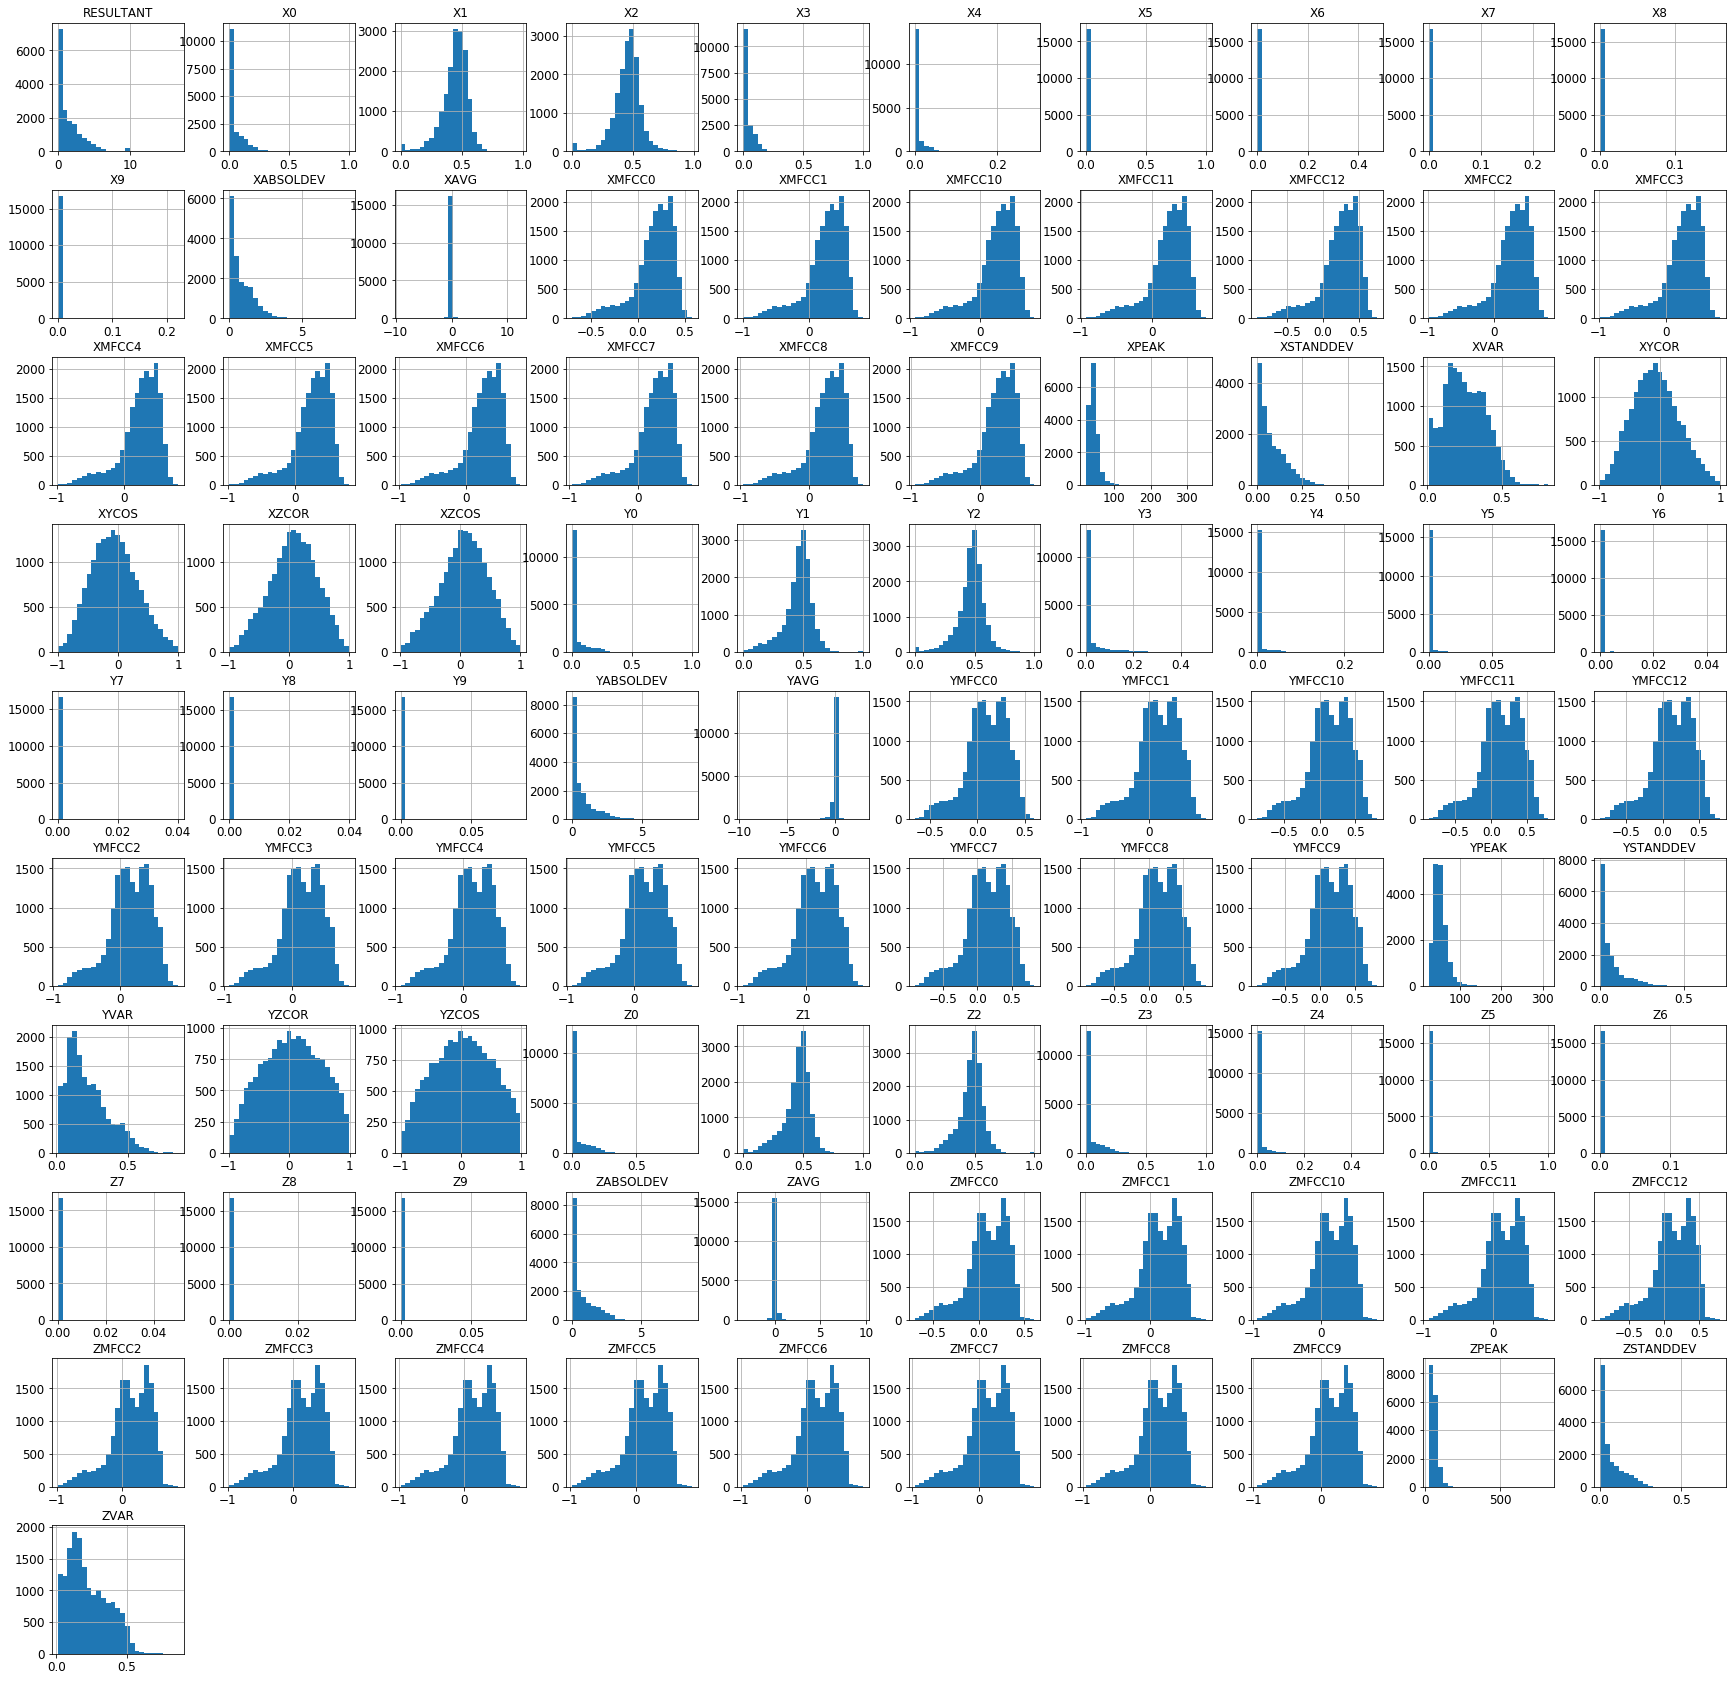

In [41]:
data_watch_gyro.hist(bins = 25, figsize=(30,30))
plt.show()

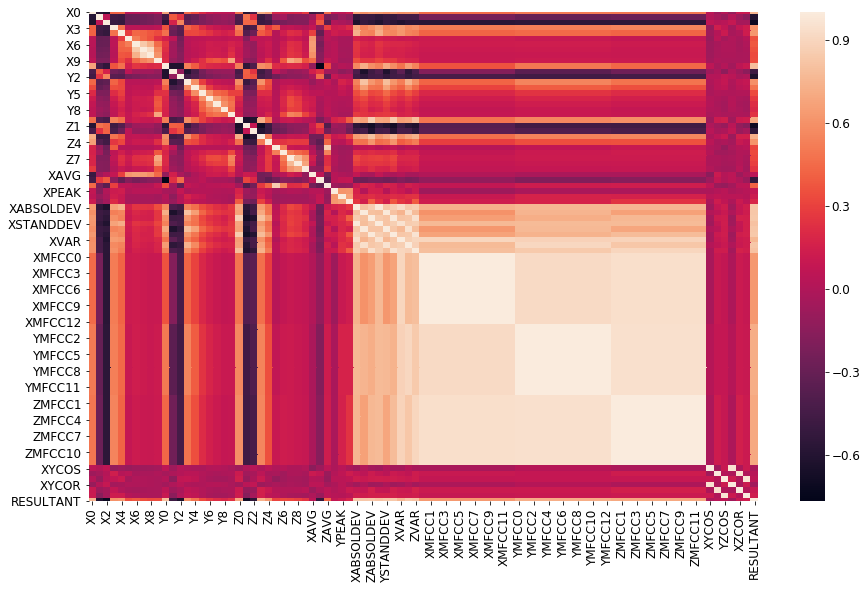

In [42]:
fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(data_watch_gyro.corr())
plt.show()

Tout comme dans l'étude précédente, les attributs MFCC ont une forte corrélation entre eux. Nous allons confirmer cela par la suite

In [43]:
thresholdCorrelation = 0.8

correlationXMFCC = correlationMatrix["XMFCC0"].sort_values(ascending=False)**2
correlationXMFCC[correlationXMFCC>=thresholdCorrelation]

XMFCC0     1.000000
XMFCC3     1.000000
XMFCC2     1.000000
XMFCC1     1.000000
XMFCC4     1.000000
XMFCC5     1.000000
XMFCC6     1.000000
XMFCC8     1.000000
XMFCC7     1.000000
XMFCC9     1.000000
XMFCC10    1.000000
XMFCC11    1.000000
XMFCC12    1.000000
ZMFCC11    0.888761
ZMFCC10    0.888761
ZMFCC1     0.888761
ZMFCC4     0.888761
ZMFCC3     0.888761
ZMFCC2     0.888761
ZMFCC12    0.888761
ZMFCC6     0.888761
ZMFCC0     0.888761
ZMFCC7     0.888761
ZMFCC5     0.888761
ZMFCC9     0.888761
ZMFCC8     0.888761
YMFCC3     0.853039
YMFCC2     0.853039
YMFCC7     0.853039
YMFCC5     0.853039
YMFCC12    0.853039
YMFCC9     0.853039
YMFCC11    0.853039
YMFCC4     0.853039
YMFCC0     0.853039
YMFCC6     0.853039
YMFCC1     0.853039
YMFCC8     0.853039
YMFCC10    0.853039
XVAR       0.813887
Name: XMFCC0, dtype: float64

In [44]:
correlationYMFCC = correlationMatrix["YMFCC0"].sort_values(ascending=False)**2
correlationYMFCC[correlationYMFCC>=thresholdCorrelation]

YMFCC0     1.000000
YMFCC4     1.000000
YMFCC2     1.000000
YMFCC8     1.000000
YMFCC3     1.000000
YMFCC5     1.000000
YMFCC1     1.000000
YMFCC6     1.000000
YMFCC7     1.000000
YMFCC12    1.000000
YMFCC9     1.000000
YMFCC10    1.000000
YMFCC11    1.000000
ZMFCC6     0.900188
ZMFCC3     0.900188
ZMFCC11    0.900188
ZMFCC0     0.900188
ZMFCC4     0.900188
ZMFCC9     0.900188
ZMFCC1     0.900188
ZMFCC5     0.900188
ZMFCC7     0.900188
ZMFCC2     0.900188
ZMFCC10    0.900188
ZMFCC8     0.900188
ZMFCC12    0.900188
XMFCC12    0.853039
XMFCC6     0.853039
XMFCC5     0.853039
XMFCC2     0.853039
XMFCC0     0.853039
XMFCC11    0.853039
XMFCC10    0.853039
XMFCC1     0.853039
XMFCC8     0.853039
XMFCC7     0.853039
XMFCC3     0.853039
XMFCC9     0.853039
XMFCC4     0.853039
YVAR       0.822101
Name: YMFCC0, dtype: float64

In [45]:
correlationZMFCC = correlationMatrix["ZMFCC0"].sort_values(ascending=False)**2
correlationZMFCC[correlationZMFCC>=thresholdCorrelation]

ZMFCC0     1.000000
ZMFCC2     1.000000
ZMFCC1     1.000000
ZMFCC4     1.000000
ZMFCC6     1.000000
ZMFCC8     1.000000
ZMFCC7     1.000000
ZMFCC3     1.000000
ZMFCC10    1.000000
ZMFCC5     1.000000
ZMFCC9     1.000000
ZMFCC11    1.000000
ZMFCC12    1.000000
YMFCC7     0.900188
YMFCC3     0.900188
YMFCC11    0.900188
YMFCC0     0.900188
YMFCC4     0.900188
YMFCC6     0.900188
YMFCC9     0.900188
YMFCC2     0.900188
YMFCC1     0.900188
YMFCC8     0.900188
YMFCC12    0.900188
YMFCC5     0.900188
YMFCC10    0.900188
XMFCC12    0.888761
XMFCC2     0.888761
XMFCC6     0.888761
XMFCC5     0.888761
XMFCC8     0.888761
XMFCC11    0.888761
XMFCC7     0.888761
XMFCC0     0.888761
XMFCC3     0.888761
XMFCC1     0.888761
XMFCC9     0.888761
XMFCC10    0.888761
XMFCC4     0.888761
ZVAR       0.814265
Name: ZMFCC0, dtype: float64

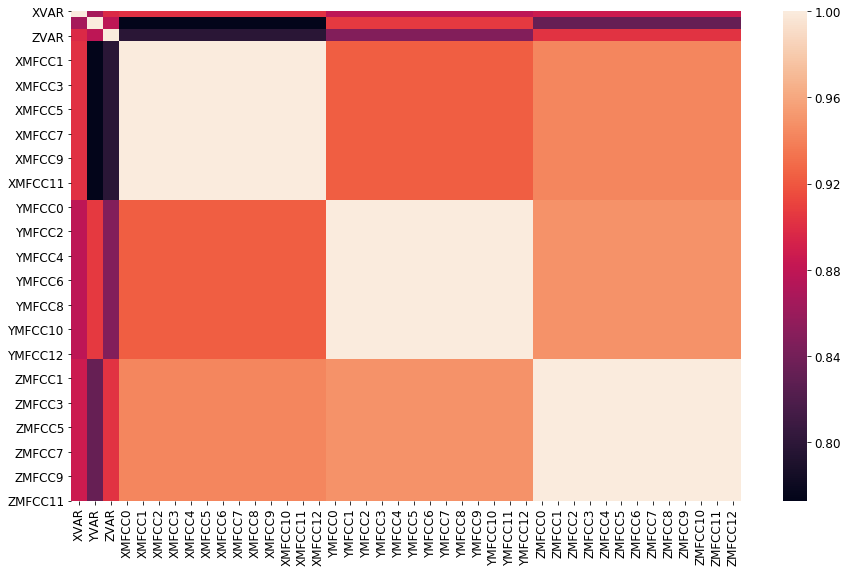

In [46]:
# Visualisation de la carte des chaleurs des attributs corrélés
VAR_Attributs = ['XVAR','YVAR','ZVAR']
correlatedAttributs = VAR_Attributs+mfccAttributs

correlated_data= attributsSelection(data_watch_gyro, correlatedAttributs)

fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(correlated_data.corr())
plt.show()

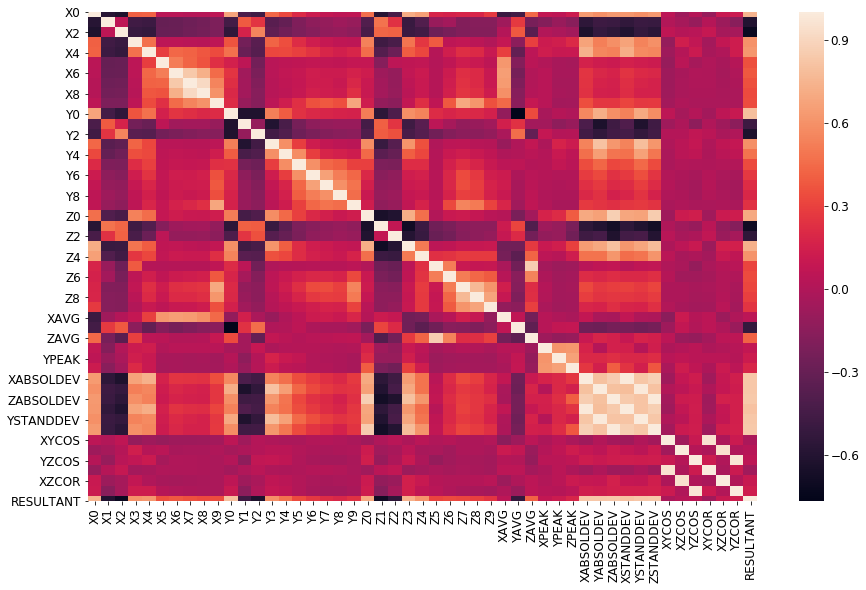

In [47]:
#Visualisation de la corrélation entre les données réduits

non_correlated_data= data_watch_gyro.drop(correlatedAttributs, axis=1)

fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(non_correlated_data.corr())
plt.show()

Il apparait sur le shéma en bas à droite que les attributs ABSOLDEV et STANDDEV sont fortement corrélés. Nous vérifions cela dans les calculs de corrélation ci-dessous.
Nous pouvons aussi remarquer que 'XYCOS' est corrélé avec XYCOR

In [48]:
correlationX = correlationMatrix["XABSOLDEV"].sort_values(ascending=False)**2
correlationX[correlationX>=thresholdCorrelation]

XABSOLDEV    1.000000
XSTANDDEV    0.975412
XVAR         0.874142
Name: XABSOLDEV, dtype: float64

In [49]:
correlationY = correlationMatrix["YABSOLDEV"].sort_values(ascending=False)**2
correlationY[correlationY>=thresholdCorrelation]

YABSOLDEV    1.000000
YSTANDDEV    0.973641
YVAR         0.881611
Name: YABSOLDEV, dtype: float64

In [50]:
correlationZ = correlationMatrix["ZABSOLDEV"].sort_values(ascending=False)**2
correlationZ[correlationZ>=thresholdCorrelation]

ZABSOLDEV    1.000000
ZSTANDDEV    0.983701
ZVAR         0.902355
Name: ZABSOLDEV, dtype: float64

In [51]:
correlationCOS1 = correlationMatrix["XYCOS"].sort_values(ascending=False)**2
correlationCOS1[correlationCOS1>=thresholdCorrelation]

XYCOS    1.000000
XYCOR    0.907299
Name: XYCOS, dtype: float64

### Etude des données venant de l'accéléromètre des téléphones
#### Vérification de la qualité des données

In [52]:
# Vérification des valeurs manquantes
data_phone_accel = data_phone_accel.replace('?',np.NaN)
print('Number of instances = %d' % (data_phone_accel.shape[0]))
print('Number of attributes = %d' % (data_phone_accel.shape[1]))

print('Number of missing values:')
for col in data_phone_accel.columns:
    print('\t%s: %d' % (col,data_phone_accel[col].isna().sum()))

Number of instances = 23401
Number of attributes = 93
Number of missing values:
	ACTIVITY: 0
	X0: 0
	X1: 0
	X2: 0
	X3: 0
	X4: 0
	X5: 0
	X6: 0
	X7: 0
	X8: 0
	X9: 0
	Y0: 0
	Y1: 0
	Y2: 0
	Y3: 0
	Y4: 0
	Y5: 0
	Y6: 0
	Y7: 0
	Y8: 0
	Y9: 0
	Z0: 0
	Z1: 0
	Z2: 0
	Z3: 0
	Z4: 0
	Z5: 0
	Z6: 0
	Z7: 0
	Z8: 0
	Z9: 0
	XAVG: 0
	YAVG: 0
	ZAVG: 0
	XPEAK: 0
	YPEAK: 0
	ZPEAK: 0
	XABSOLDEV: 0
	YABSOLDEV: 0
	ZABSOLDEV: 0
	XSTANDDEV: 0
	YSTANDDEV: 0
	ZSTANDDEV: 0
	XVAR: 0
	YVAR: 0
	ZVAR: 0
	XMFCC0: 0
	XMFCC1: 0
	XMFCC2: 0
	XMFCC3: 0
	XMFCC4: 0
	XMFCC5: 0
	XMFCC6: 0
	XMFCC7: 0
	XMFCC8: 0
	XMFCC9: 0
	XMFCC10: 0
	XMFCC11: 0
	XMFCC12: 0
	YMFCC0: 0
	YMFCC1: 0
	YMFCC2: 0
	YMFCC3: 0
	YMFCC4: 0
	YMFCC5: 0
	YMFCC6: 0
	YMFCC7: 0
	YMFCC8: 0
	YMFCC9: 0
	YMFCC10: 0
	YMFCC11: 0
	YMFCC12: 0
	ZMFCC0: 0
	ZMFCC1: 0
	ZMFCC2: 0
	ZMFCC3: 0
	ZMFCC4: 0
	ZMFCC5: 0
	ZMFCC6: 0
	ZMFCC7: 0
	ZMFCC8: 0
	ZMFCC9: 0
	ZMFCC10: 0
	ZMFCC11: 0
	ZMFCC12: 0
	XYCOS: 0
	XZCOS: 0
	YZCOS: 0
	XYCOR: 0
	XZCOR: 0
	YZCOR: 0
	RESULTANT: 0
	class: 0


In [53]:
# Vérification des doublons
dups = data_phone_accel.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 2424


In [54]:
# Suppréssion des doublons
print('Number of rows before discarding duplicates = %d' % (data_phone_accel.shape[0]))
data_phone_accel = data_phone_accel.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data_phone_accel.shape[0]))


Number of rows before discarding duplicates = 23401
Number of rows after discarding duplicates = 20977


#### Compréhension des données et affichage des détails statistiques des sujets 

In [55]:
data_phone_accel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20977 entries, 0 to 423
Data columns (total 93 columns):
ACTIVITY     20977 non-null object
X0           20977 non-null float64
X1           20977 non-null float64
X2           20977 non-null float64
X3           20977 non-null float64
X4           20977 non-null float64
X5           20977 non-null float64
X6           20977 non-null float64
X7           20977 non-null float64
X8           20977 non-null float64
X9           20977 non-null float64
Y0           20977 non-null float64
Y1           20977 non-null float64
Y2           20977 non-null float64
Y3           20977 non-null float64
Y4           20977 non-null float64
Y5           20977 non-null float64
Y6           20977 non-null float64
Y7           20977 non-null float64
Y8           20977 non-null float64
Y9           20977 non-null float64
Z0           20977 non-null float64
Z1           20977 non-null float64
Z2           20977 non-null float64
Z3           20977 non-null fl

In [56]:
data_phone_accel.head()

,ACTIVITY,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT,class
0,A,0.0,0.0,0.0,0.045,0.090,0.190,0.215,0.210,0.135,...,0.504662,0.498178,-0.395887,-0.105039,-0.263814,-0.035912,-0.305539,-0.292265,12.7783,1600
1,A,0.0,0.0,0.0,0.000,0.030,0.250,0.305,0.225,0.125,...,0.497101,0.490714,-0.517585,-0.493655,0.208926,-0.166636,0.071774,-0.070860,12.8712,1600
2,A,0.0,0.0,0.0,0.000,0.015,0.280,0.300,0.210,0.140,...,0.438027,0.432398,-0.573148,-0.468498,0.001704,-0.090878,0.005053,-0.382557,12.5949,1600
3,A,0.0,0.0,0.0,0.005,0.070,0.245,0.275,0.220,0.130,...,0.447493,0.441743,-0.514097,-0.232246,-0.080241,-0.117089,0.137656,-0.265747,12.3521,1600
4,A,0.0,0.0,0.0,0.000,0.015,0.260,0.325,0.230,0.110,...,0.433304,0.427736,-0.461254,0.084470,-0.418888,-0.097265,-0.118795,-0.414198,12.4168,1600


In [57]:
data_phone_accel.describe()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
count,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,...,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000,20977.000000
mean,0.316723,0.172123,0.153417,0.133571,0.106095,0.094788,0.012781,0.004747,0.002287,0.003469,...,0.371424,0.367100,0.362383,0.033416,-0.093391,0.131664,-0.034665,0.035455,0.002631,10.107874
std,0.422170,0.298210,0.275894,0.282479,0.267338,0.261109,0.052383,0.021044,0.010778,0.021112,...,0.175469,0.173426,0.171197,0.842840,0.796821,0.801206,0.410925,0.426328,0.397249,1.150532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.391369,-0.386813,-0.381842,-0.999993,-0.999997,-0.999988,-0.999833,-0.999966,-0.999915,9.092720
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.275671,0.272462,0.268961,-0.956638,-0.994589,-0.795967,-0.304648,-0.252510,-0.249237,9.586950
50%,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.394843,0.390246,0.385231,0.076763,-0.141232,0.293940,-0.024475,0.033580,0.002180,9.862430
75%,0.890000,0.210000,0.205000,0.105000,0.045000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.458963,0.453620,0.447791,0.972784,0.802817,0.991608,0.237114,0.327699,0.251212,10.151500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.295000,0.170000,0.335000,...,0.847427,0.837561,0.826799,0.999996,0.999997,0.999996,0.999944,0.999865,0.999935,23.154900


In [58]:
print('Covariance')
data_watch_accel.cov()

Covariance


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
X0,0.157552,-0.030058,-0.032447,-0.017648,-0.017345,-0.036973,-0.013135,-0.005094,-0.002080,-0.002773,...,-0.000664,-0.000656,-0.000648,0.163605,-0.055605,-0.000709,-0.032439,0.032166,0.005999,-0.042378
X1,-0.030058,0.081689,-0.003661,-0.008601,-0.008633,-0.018615,-0.006800,-0.002715,-0.001147,-0.001461,...,-0.002946,-0.002912,-0.002875,0.073418,-0.045857,-0.032835,-0.007573,0.014745,0.010110,-0.095581
X2,-0.032447,-0.003661,0.057491,-0.001015,-0.003220,-0.010570,-0.003914,-0.001503,-0.000589,-0.000573,...,-0.000005,-0.000005,-0.000005,-0.046856,0.044267,-0.016588,0.012164,0.000611,0.006913,-0.043482
X3,-0.017648,-0.008601,-0.001015,0.027073,0.003496,-0.002442,-0.000909,-0.000210,0.000002,0.000253,...,0.002199,0.002173,0.002145,-0.035584,0.016309,0.008209,0.008030,-0.007379,-0.004118,0.009163
X4,-0.017345,-0.008633,-0.003220,0.003496,0.017129,0.003996,0.002282,0.001150,0.000507,0.000639,...,0.003609,0.003567,0.003521,-0.027642,0.007586,0.009639,0.005452,-0.008931,-0.004616,0.029165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YZCOS,-0.000709,-0.032835,-0.016588,0.008209,0.009639,0.013069,0.010411,0.004258,0.002012,0.002534,...,0.011602,0.011467,0.011319,-0.056632,0.025809,0.409765,-0.000343,-0.066988,-0.022152,0.207246
XYCOR,-0.032439,-0.007573,0.012164,0.008030,0.005452,0.016038,-0.000409,-0.000392,-0.000209,-0.000664,...,0.002470,0.002442,0.002410,-0.061631,0.009577,-0.000343,0.183230,0.021675,0.015436,0.016951
XZCOR,0.032166,0.014745,0.000611,-0.007379,-0.008931,-0.017575,-0.006938,-0.003543,-0.001625,-0.001530,...,0.002705,0.002673,0.002639,0.064411,-0.042955,-0.066988,0.021675,0.217870,-0.027441,-0.069872
YZCOR,0.005999,0.010110,0.006913,-0.004118,-0.004616,-0.005273,-0.003821,-0.002048,-0.000926,-0.002221,...,-0.006304,-0.006231,-0.006151,0.030031,-0.046675,-0.022152,0.015436,-0.027441,0.192892,-0.091359


In [59]:
correlationMatrix = data_phone_accel.corr()
print('Correlation :')
data_phone_accel.corr()

Correlation :


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,ZMFCC10,ZMFCC11,ZMFCC12,XYCOS,XZCOS,YZCOS,XYCOR,XZCOR,YZCOR,RESULTANT
X0,1.000000,-0.273639,-0.342312,-0.319428,-0.278697,-0.261155,-0.154618,-0.130352,-0.106854,-0.057053,...,-0.041491,-0.041491,-0.041491,0.286376,0.052203,-0.146870,-0.087081,0.000118,0.091712,-0.026331
X1,-0.273639,1.000000,-0.039157,-0.203457,-0.201816,-0.196118,-0.110996,-0.090923,-0.071786,-0.035455,...,0.008827,0.008827,0.008827,0.142530,-0.044464,-0.084574,-0.021817,-0.027080,0.036300,-0.060430
X2,-0.342312,-0.039157,1.000000,-0.070335,-0.169940,-0.180334,-0.090500,-0.069519,-0.052846,-0.025710,...,-0.034390,-0.034390,-0.034390,-0.106703,0.130225,-0.039919,0.057168,-0.055678,-0.004024,-0.012381
X3,-0.319428,-0.203457,-0.070335,1.000000,-0.095639,-0.144369,-0.056191,-0.031955,-0.023949,-0.019419,...,0.036026,0.036026,0.036026,-0.180277,-0.035013,0.089353,0.041242,0.027069,-0.106611,-0.012735
X4,-0.278697,-0.201816,-0.169940,-0.095639,1.000000,-0.064408,0.007717,0.030450,0.022221,-0.002986,...,0.078869,0.078869,0.078869,-0.178859,-0.089421,0.220632,0.037872,0.011362,-0.112667,-0.012778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YZCOS,-0.146870,-0.084574,-0.039919,0.089353,0.220632,0.070033,-0.030773,-0.042519,-0.049978,-0.058081,...,0.010426,0.010426,0.010426,-0.135459,0.061700,1.000000,0.025387,-0.129316,-0.246418,-0.034332
XYCOR,-0.087081,-0.021817,0.057168,0.041242,0.037872,0.027062,0.003555,-0.033867,-0.025913,-0.025492,...,0.019949,0.019949,0.019949,-0.292175,-0.033755,0.025387,1.000000,0.033133,0.025038,0.007564
XZCOR,0.000118,-0.027080,-0.055678,0.027069,0.011362,0.056965,-0.009510,-0.029938,-0.034297,-0.031905,...,0.022886,0.022886,0.022886,-0.083068,-0.297786,-0.129316,0.033133,1.000000,-0.004966,-0.022981
YZCOR,0.091712,0.036300,-0.004024,-0.106611,-0.112667,0.060541,-0.017478,-0.043859,-0.058894,-0.072566,...,-0.052391,-0.052391,-0.052391,0.033538,-0.021602,-0.246418,0.025038,-0.004966,1.000000,-0.059783


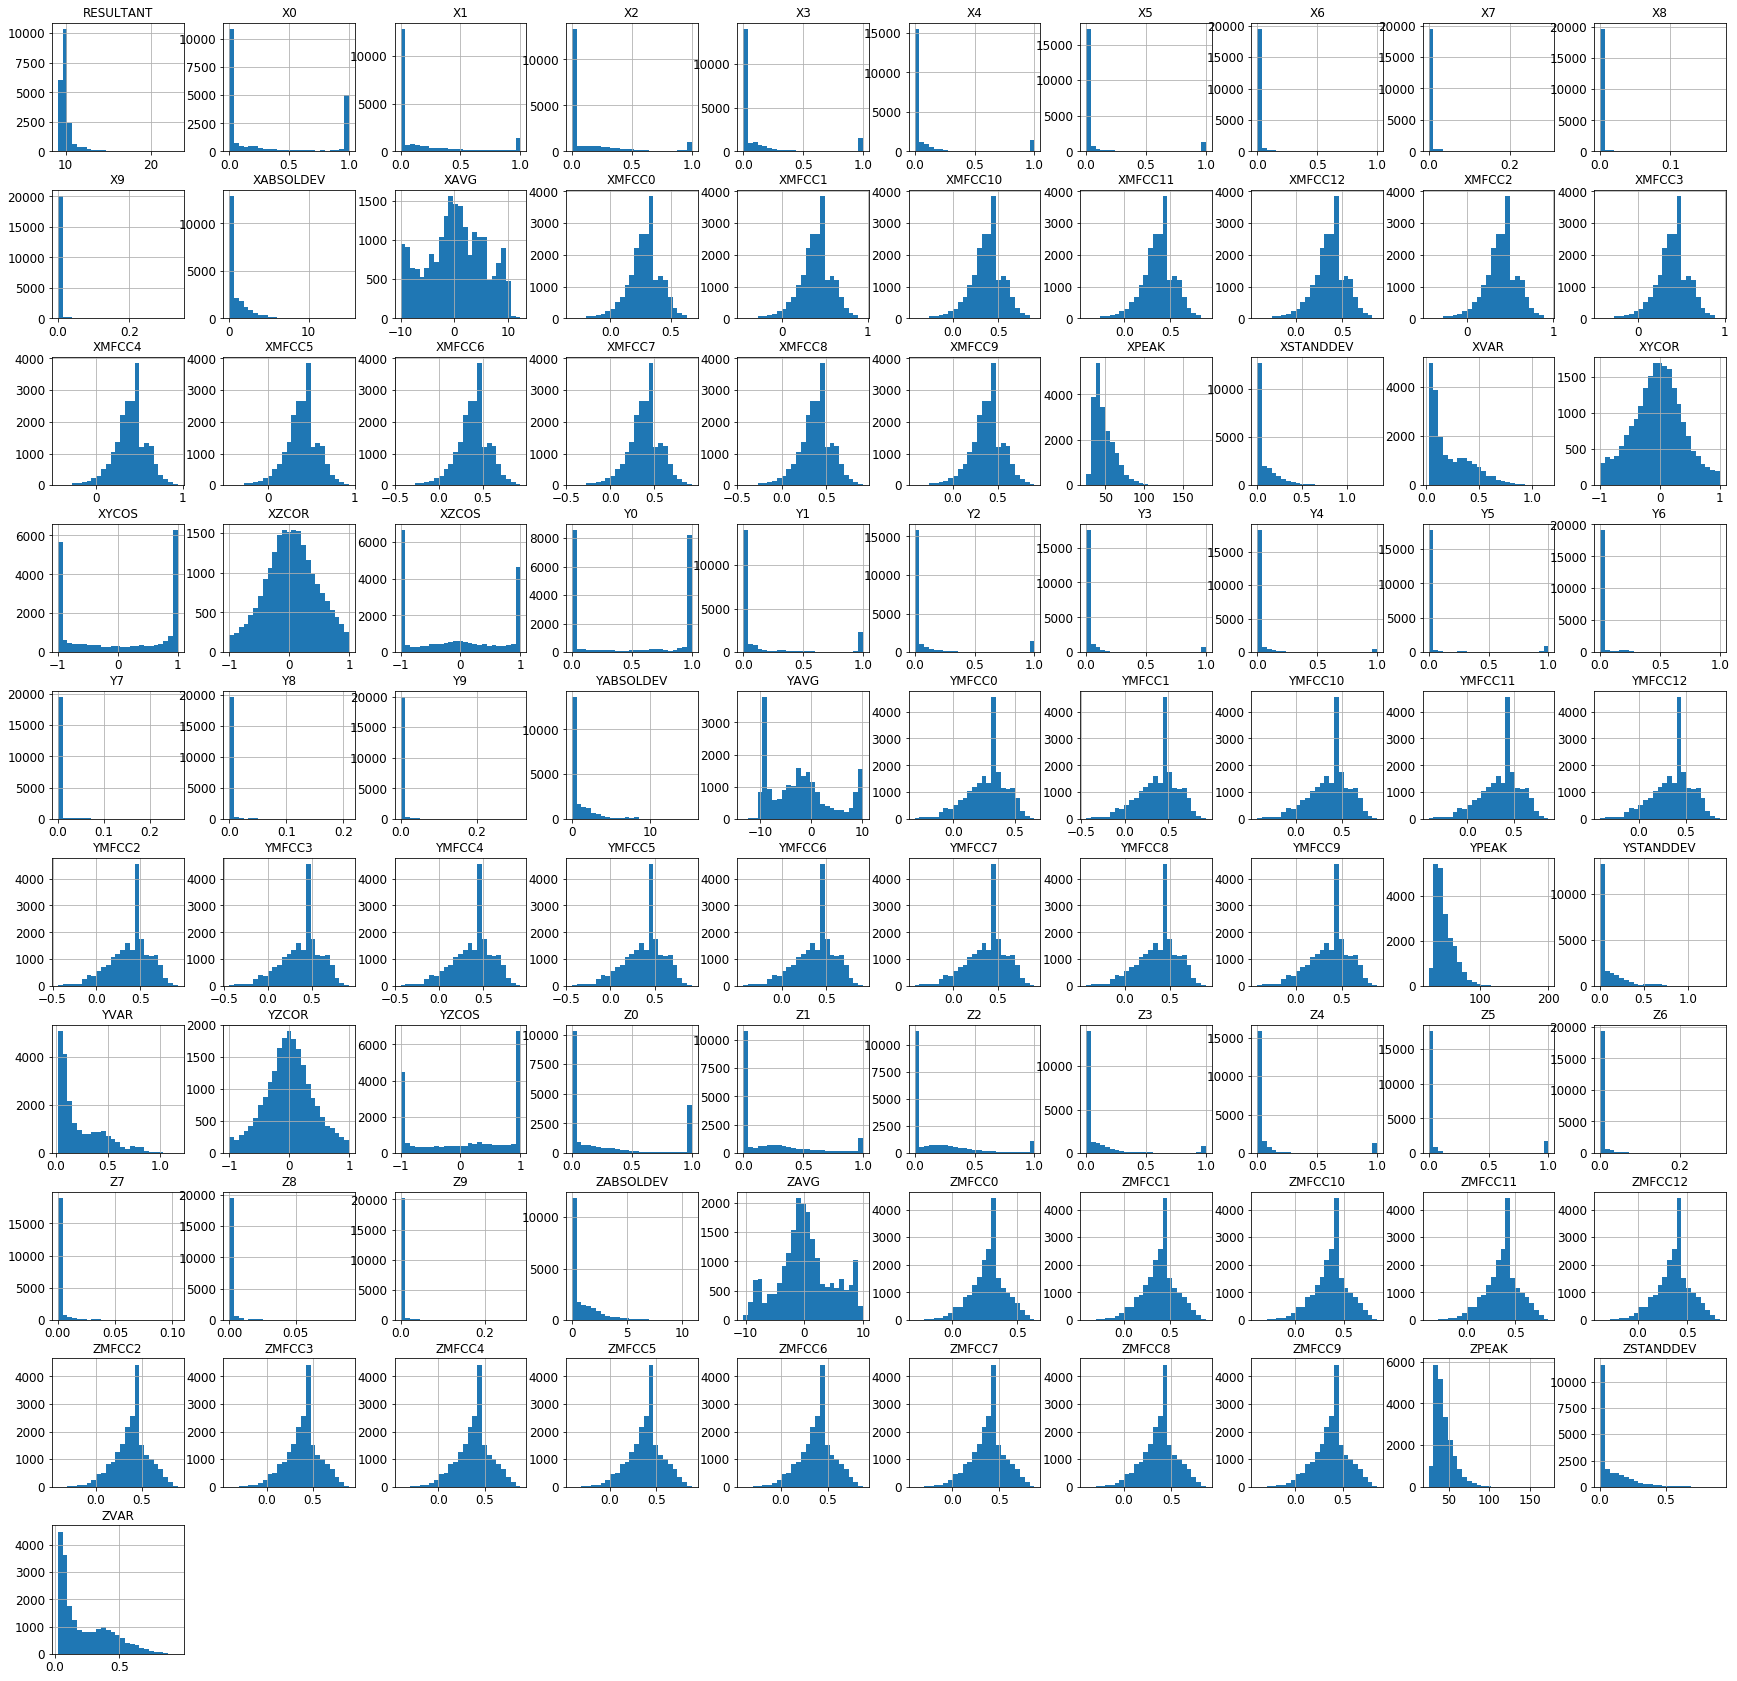

In [60]:
#Affichage de l'histogramme des données
data_phone_accel.hist(bins = 25, figsize=(30,30))
plt.show()

Saving figure Figure


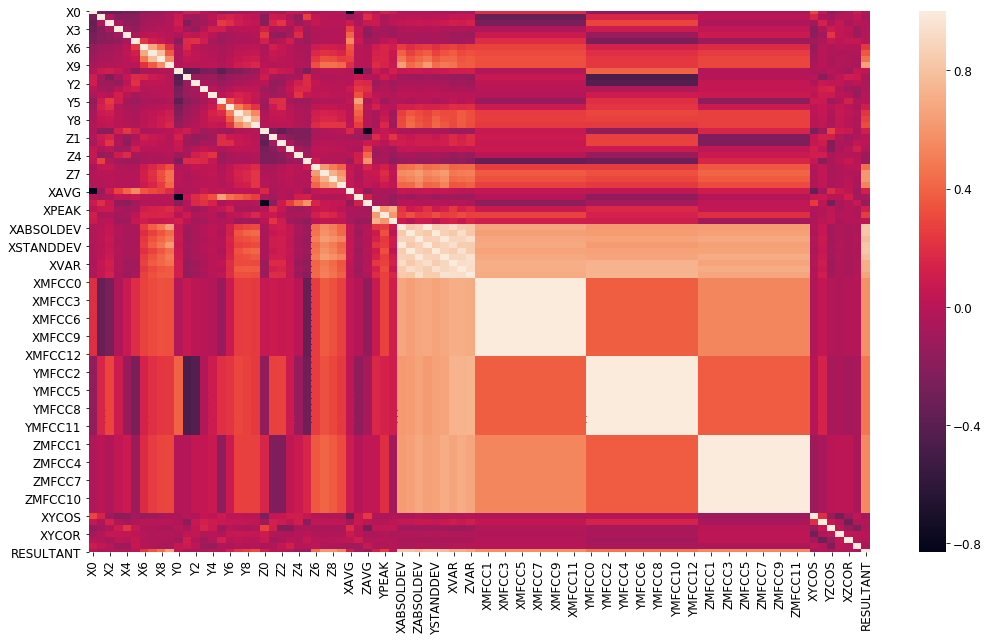

In [124]:
# Visualisation de la corrélation entre les attributs

fig, ax = plt.subplots(figsize=(15,9))
heat_map = sns.heatmap(data_phone_accel.corr())
save_fig("Figure")
plt.show()

Tout comme dans les études précédentes, les attributs MFCC semblent avoir une corrélation égale à 1. Aussi, les attributs ABSOLDEV semblent être corrélés avec d'autres attributs. De même, X{6-9}, Y{6-9} et Z{6-9} ont une très faible variance d'après leurs histogrammes. Dans la phase de modélisation, nous allons donc étudier les performances des modèles lorsque ses attributs ne sont pas utilisés.

In [62]:
thresholdCorrelation = 0.8

correlationXMFCC = correlationMatrix["XMFCC0"].sort_values(ascending=False)**2
correlationXMFCC[correlationXMFCC>=thresholdCorrelation]

XMFCC0     1.0
XMFCC4     1.0
XMFCC1     1.0
XMFCC6     1.0
XMFCC3     1.0
XMFCC5     1.0
XMFCC2     1.0
XMFCC8     1.0
XMFCC7     1.0
XMFCC9     1.0
XMFCC10    1.0
XMFCC11    1.0
XMFCC12    1.0
Name: XMFCC0, dtype: float64

In [63]:
correlationYMFCC = correlationMatrix["YMFCC0"].sort_values(ascending=False)**2
correlationYMFCC[correlationYMFCC>=thresholdCorrelation]

YMFCC0     1.0
YMFCC6     1.0
YMFCC5     1.0
YMFCC1     1.0
YMFCC2     1.0
YMFCC4     1.0
YMFCC7     1.0
YMFCC8     1.0
YMFCC3     1.0
YMFCC9     1.0
YMFCC10    1.0
YMFCC12    1.0
YMFCC11    1.0
Name: YMFCC0, dtype: float64

In [64]:
correlationZMFCC = correlationMatrix["ZMFCC0"].sort_values(ascending=False)**2
correlationZMFCC[correlationZMFCC>=thresholdCorrelation]

ZMFCC0     1.0
ZMFCC2     1.0
ZMFCC3     1.0
ZMFCC1     1.0
ZMFCC5     1.0
ZMFCC6     1.0
ZMFCC9     1.0
ZMFCC4     1.0
ZMFCC7     1.0
ZMFCC8     1.0
ZMFCC12    1.0
ZMFCC11    1.0
ZMFCC10    1.0
Name: ZMFCC0, dtype: float64

In [65]:
correlationXABSOLDEV = correlationMatrix["XABSOLDEV"].sort_values(ascending=False)**2
correlationXABSOLDEV[correlationXABSOLDEV>=thresholdCorrelation]

XABSOLDEV    1.000000
XSTANDDEV    0.988359
XVAR         0.869604
Name: XABSOLDEV, dtype: float64

### Modélisation

#### En considérant les données de l'accéléromètre des smartwatches
##### Arbre de décision

In [66]:
#sans enlever les attributs jugés non pertinents
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

irrelevant_attributs = ['ACTIVITY','class']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

feature_names = list(X.columns)
target_names=Y.unique()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42).fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.52 (+/- 0.17)


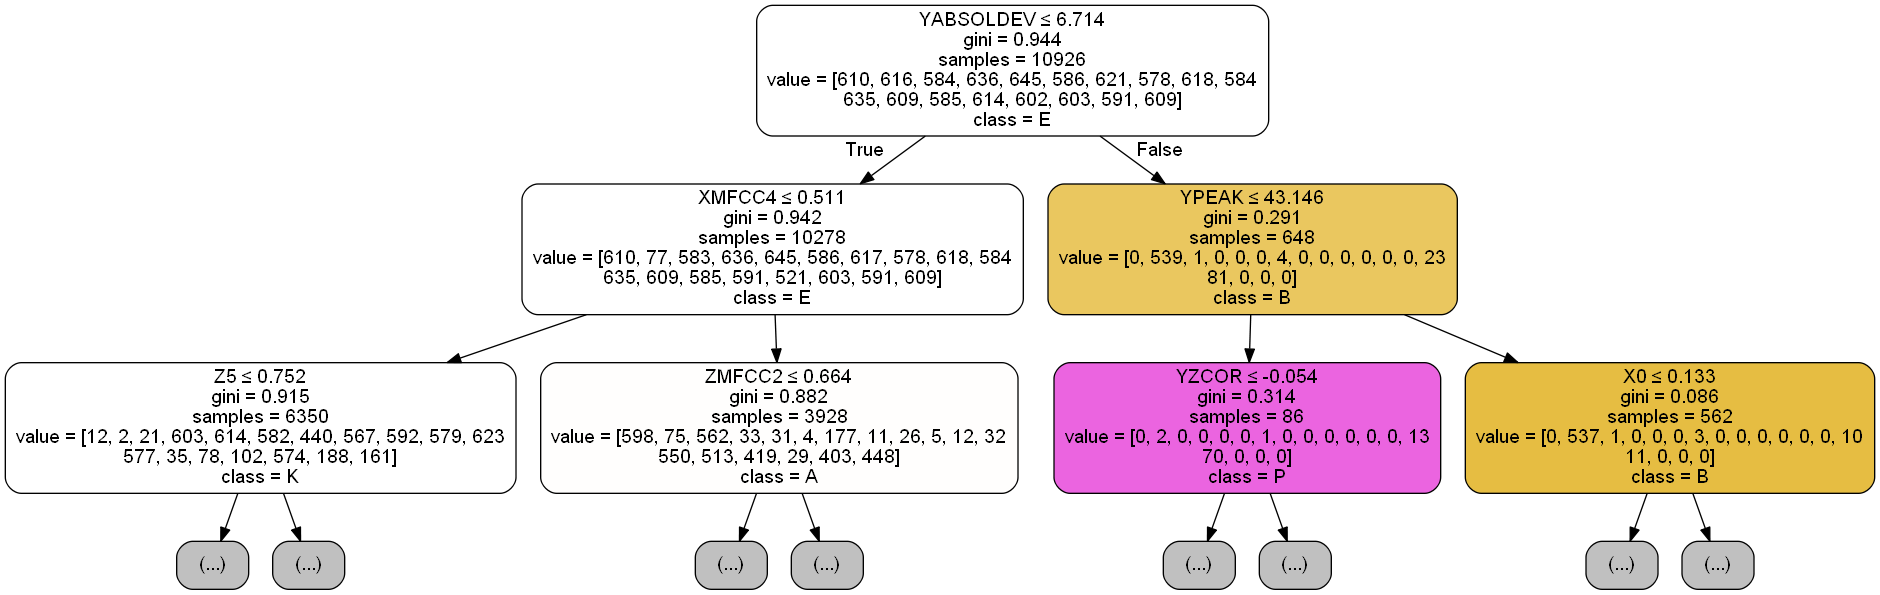

In [67]:
import graphviz 
from sklearn.tree import export_graphviz

# Affichage de l'arbre de décision créé
dot_tree = tree.export_graphviz(clf, out_file=None, 
                     feature_names=feature_names,  
                     class_names=target_names,  
                     filled=True, rounded=True,  
                     special_characters=True,max_depth=2)


graph_tree = graphviz.Source(dot_tree)

png_bytes = graph_tree.pipe(format='png')
path=os.path.join(IMAGES_PATH,'Arbre de décision.png')
with open(path,'wb') as f:
    f.write(png_bytes)
f.close()

from IPython.display import Image
Image(png_bytes)

In [68]:
#en enlevant les attributs corrélés et ceux ayant une très faible variance
lowVarianceAttributs = ['X4', 'X6', 'X7', 'X8', 'X9', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7','Y8','Y9',
                      'Z6','Z7','Z8','Z9']

irrelevant_attributs = ['ACTIVITY','class']+mfccAttributsToDrop+XYZattributsToDrop+lowVarianceAttributs
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42).fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.52 (+/- 0.13)


In [69]:
#en enlevant les attributs que les chercheurs n'utilisent pas

irrelevant_attributs = ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.53 (+/- 0.12)


##### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

#sans enlever d'attributs
irrelevant_attributs = ['ACTIVITY','class']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.66 (+/- 0.18)


In [71]:
#en enlevant les attributs non pertinents

irrelevant_attributs = ['ACTIVITY','class']+mfccAttributsToDrop+XYZattributsToDrop+lowVarianceAttributs
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.16)


In [72]:
# en enlevant les attributs non utilisés par les chercheurs

irrelevant_attributs = ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.66 (+/- 0.17)


##### SVM holdhout

In [73]:
from sklearn.model_selection import train_test_split
from sklearn import svm

#sans enlever d'attributs
irrelevant_attributs = ['ACTIVITY','class']
Y = data_watch_accel['ACTIVITY']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.774468085106383


In [74]:
# en enlevant les attributs non pertinents
irrelevant_attributs = ['ACTIVITY','class']+mfccAttributsToDrop+XYZattributsToDrop+lowVarianceAttributs
Y = data_watch_accel['ACTIVITY']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.7417982155113246


La performance a baissé mais reste à un niveau élevé. Néanmoins, en n'enlevant que les attributs à faible dispersion (c'est-à-dire les {X{6-9},Y{6-9},Z{6-9}), on arrive à maintenir la précision de 77%. Nous n'enlèverons donc que ces attributs là pour ce modèle.

De plus, après avoir essayé plusieurs noyaux, 'rbf' est celui qui a donnée le meilleur résultat pour SVM, en mettant C = 1000 et gamma = 'scale'. Les autres paramètres ne donnent pas de meilleurs résultats et ont un temps d'éxécution plus long.

In [75]:
# en enlevant les attributs que les chercheurs n'utilisent pas 
irrelevant_attributs = ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.7294440631434455


##### SVM cross-validation
Une fois que l'on a déterminé les bons paramètres pour la fonction SVC, nous allons procéder ici à la mise en place de SVM avec une validation croisée à K = 10

In [76]:
from sklearn.model_selection import cross_val_score
# en enlevant les attributs non pertinents

irrelevant_attributs = ['ACTIVITY','class']+lowVarianceAttributs
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.62 (+/- 0.19)


In [77]:
# en n'enlevant aucun attribut

irrelevant_attributs =  ['ACTIVITY','class']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.62 (+/- 0.19)


In [78]:
# en enlevant les attributs que les chercheurs n'utilisent pas 

irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_watch_accel.drop(irrelevant_attributs, axis=1)
Y = data_watch_accel['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.18)


##### SVM GridSearch avec cross validation

En raison du très grand nombre de données à traiter et de la limite de nos laptops, la recherche des meilleurs paramètres avec SVM GridSearch n'a pas pu aboutir dans le cas d'un modèle impersonnel car le temps de calcul est trop élevé. L'algorithme a été lancé mais au bout de 30 min, il n'a toujours pas abouti à un résultat. Les paramètres importants ont donc été recherché à la main.

##### Bayésien naïf

In [79]:
from sklearn.naive_bayes import GaussianNB

# sans enlever d'attributs
irrelevant_attributs =  ['ACTIVITY','class']

Y=data_watch_accel['ACTIVITY']
X=data_watch_accel.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.38 (+/- 0.11)


In [80]:
# en enlevant les attributs jugés non pertinents lors de la séléction des données

irrelevant_attributs =  ['ACTIVITY','class']+mfccAttributsToDrop+XYZattributsToDrop+lowVarianceAttributs

Y=data_watch_accel['ACTIVITY']
X=data_watch_accel.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.45 (+/- 0.17)


In [81]:
# en enlevant les attributs non utilisés par les chercheurs

irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']

Y=data_watch_accel['ACTIVITY']
X=data_watch_accel.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.39 (+/- 0.16)


#### En considérant les données du gyroscope des smartwatches
##### Arbre de décision

D'après les études effectuées précédemment, les attributs MFCC, ayant une corrélation entre eux égale à 1 peuvent ne pas être utilisé. De même, attributs ABSOLDEV et STANDDEV sont très corrélés entre eux, COR ET COS aussi. Il y a aussi les attributs X{6-9}, Y{6-9} et Z{6-9} qui ont une variance très faible.


In [120]:
correlatedAttributsToDrop = mfccAttributs+XYZattributsToDrop+['XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'XVAR', 'YVAR', 'ZVAR']+['XYCOR'] 

lowVarianceAttributsToDrop  = ['X6', 'X7', 'X8', 'X9', 'Y6', 'Y7','Y8','Y9','Z6','Z7','Z8','Z9']



In [121]:
# sans enlever les attributs 
irrelevant_attributs = ['ACTIVITY','class']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.45 (+/- 0.14)


In [122]:
# en enlevant les attributs corrélés et à faible variance
irrelevant_attributs = ['ACTIVITY','class']+correlatedAttributsToDrop+lowVarianceAttributsToDrop
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.41 (+/- 0.14)


In [85]:
# en enlevant les attributs non utilisés par les chercheurs
irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.43 (+/- 0.14)


##### Random Forest

In [86]:
#sans enlever d'attributs

irrelevant_attributs = ['ACTIVITY','class']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.57 (+/- 0.17)


In [123]:
# en enlevant les attributs non pertinents

irrelevant_attributs = ['ACTIVITY','class']+correlatedAttributsToDrop+lowVarianceAttributsToDrop
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.57 (+/- 0.18)


In [88]:
# en enlevant les attributs non utilisés par les chercheurs

irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.57 (+/- 0.17)


##### SVM holdout

In [89]:
# sans enlever d'attributs
irrelevant_attributs = ['ACTIVITY','class']
Y = data_watch_gyro['ACTIVITY']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.5923784104389087


En essayant les paramètres suivants : kernel='linear', C=10, on atteint une précision de 60%. Néanmoins, le temps d'exécution est trop élevé, c'est pour cela que nous allons utiliser kernel = 'rbf' et C= 1000 car avec ces paramètres, la construction du modèle prend moins de temps.

In [90]:
# en enlevant les attributs non pertinents
irrelevant_attributs = ['ACTIVITY','class']+lowVarianceAttributsToDrop
Y = data_watch_gyro['ACTIVITY']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.591785290628707


Ici, on a décidé de garder les attributs correlés car quand on ne les prend pas en compte, la précision descend jusqu'à 51%. On n'enlève donc que les attributs X{6-9}, Y{6-9} et Z{6-9}

In [91]:
# en enlevant les attributs non utilisés par les chercheurs
irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
Y = data_watch_gyro['ACTIVITY']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.501779359430605


SVM cross-validation

In [92]:
# sans enlever les attributs

irrelevant_attributs = ['ACTIVITY','class']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.52 (+/- 0.17)


In [93]:
# en enlevant les attributs non pertinents

irrelevant_attributs = ['ACTIVITY','class']+lowVarianceAttributsToDrop
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.52 (+/- 0.17)


In [94]:
# en enlevant les attributs non utilisés par les chercheurs

irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_watch_gyro.drop(irrelevant_attributs, axis=1)
Y = data_watch_gyro['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.45 (+/- 0.16)


##### Bayésien naïf

In [95]:
# sans enlever d'attributs
irrelevant_attributs =  ['ACTIVITY','class']

Y=data_watch_gyro['ACTIVITY']
X=data_watch_gyro.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.29 (+/- 0.05)


In [96]:
# en enlevant les attributs non pertinents
irrelevant_attributs = ['ACTIVITY','class']+correlatedAttributsToDrop+lowVarianceAttributsToDrop

Y=data_watch_gyro['ACTIVITY']
X=data_watch_gyro.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.26 (+/- 0.07)


In [97]:
# en enlevant les attributs non utilisés par les chercheurs
irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']

Y=data_watch_gyro['ACTIVITY']
X=data_watch_gyro.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.21 (+/- 0.05)


#### En considérant les données de l'accéléromètre des téléphones
##### Arbre de décision

D'après les études effectuées précédemment, les attributs MFCC sont corréles entre eux, avec une corrélation égale à 1. Il y a aussi les attributs X{6-9}, Y{6-9} et Z{6-9} qui ont une variance très faible.


In [98]:
# sans enlever d'attributs
irrelevant_attributs =  ['ACTIVITY','class']

Y=data_phone_accel['ACTIVITY']
X=data_phone_accel.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42).fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.30 (+/- 0.08)


In [99]:
# en enlevant les attributs non pertinents

irrelevant_attributs =  ['ACTIVITY','class']+lowVarianceAttributsToDrop+mfccAttributsToDrop

Y=data_phone_accel['ACTIVITY']
X=data_phone_accel.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42).fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.28 (+/- 0.09)


In [100]:
# en enlevant les attributs non utilisés par les chercheurs

irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']

Y=data_phone_accel['ACTIVITY']
X=data_phone_accel.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = tree.DecisionTreeClassifier(random_state=42).fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.29 (+/- 0.07)


##### Random Forest

In [101]:
# sans enlever d'attributs

irrelevant_attributs = ['ACTIVITY','class']
X = data_phone_accel.drop(irrelevant_attributs, axis=1)
Y = data_phone_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.38 (+/- 0.08)


In [102]:
# en enlevant les attributs non pertinents

irrelevant_attributs =  ['ACTIVITY','class']+lowVarianceAttributsToDrop+mfccAttributsToDrop
X = data_phone_accel.drop(irrelevant_attributs, axis=1)
Y = data_phone_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.37 (+/- 0.08)


In [103]:
# en enlevant les attributs non utilisés par les chercheurs

irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_phone_accel.drop(irrelevant_attributs, axis=1)
Y = data_phone_accel['ACTIVITY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
clf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, Y_train)

scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.37 (+/- 0.08)


##### SVM holdout

In [104]:
# sans enlever d'attributs
irrelevant_attributs = ['ACTIVITY','class']
Y = data_phone_accel['ACTIVITY']
X = data_phone_accel.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.5890835418901204


In [105]:
# en enlevant les attributs non pertinents 
irrelevant_attributs =  ['ACTIVITY','class']+lowVarianceAttributsToDrop+mfccAttributsToDrop
Y = data_phone_accel['ACTIVITY']
X = data_phone_accel.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.5703730187105231


In [106]:
# en enlevant les attributs non utilisés par les chercheurs
irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
Y = data_phone_accel['ACTIVITY']
X = data_phone_accel.drop(irrelevant_attributs, axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale').fit(X_train, Y_train)
print('Accuracy : '+str(clf.score(X_test, Y_test))) 

Accuracy : 0.5118579430342033


##### SVM cross-validation

In [107]:
# sans enlever les attributs

irrelevant_attributs = ['ACTIVITY','class']
X = data_phone_accel.drop(irrelevant_attributs, axis=1)
Y = data_phone_accel['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.31 (+/- 0.06)


In [108]:
# en enlevant les attributs non pertinents

irrelevant_attributs =  ['ACTIVITY','class']+lowVarianceAttributsToDrop+mfccAttributsToDrop
X = data_phone_accel.drop(irrelevant_attributs, axis=1)
Y = data_phone_accel['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.29 (+/- 0.06)


In [109]:
# en enlevant les attributs non utilisés par les chercheurs

irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']
X = data_phone_accel.drop(irrelevant_attributs, axis=1)
Y = data_phone_accel['ACTIVITY']

clf = svm.SVC(kernel='rbf', C=1000, gamma = 'scale')
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.28 (+/- 0.05)


##### Bayésien naïf

In [110]:
# sans enlever d'attributs
irrelevant_attributs =  ['ACTIVITY','class']

Y=data_phone_accel['ACTIVITY']
X=data_phone_accel.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.23 (+/- 0.05)


In [111]:
# en enlevant les attributs non pertinents
irrelevant_attributs =  ['ACTIVITY','class']+lowVarianceAttributsToDrop+mfccAttributsToDrop

Y=data_phone_accel['ACTIVITY']
X=data_phone_accel.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.24 (+/- 0.06)


In [112]:
# en enlevant les attributs non utilisés par les chercheurs
irrelevant_attributs =  ['ACTIVITY','class']+['XVAR', 'YVAR', 'ZVAR']+mfccAttributs+['XYCOS', 'XZCOS', 'YZCOS', 'XYCOR','XZCOR', 'YZCOR']

Y=data_phone_accel['ACTIVITY']
X=data_phone_accel.drop(irrelevant_attributs, axis=1)

clf = GaussianNB()
scores = cross_val_score(clf, X, Y, cv=10, n_jobs = -1)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.19 (+/- 0.07)
